The project is aimed at showing the skills acquired in: 
- data acquisition;
- data visualization;
- exploratory analysis of the series;
- exploratory portfolio analysis;
- prediction of returns.

using the Python libraries introduced in the labs (Pandas, Matplotlib, Numpy, ScikitLearn, StatsModels etc.) and the main functions of each.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

we have to choose at least 6 shares of the American market to analyse, representative of 3 different sectors (for example banks, automobiles, mining, telecommunications ...).
The period to be analyzed is 30.11.2012 – 30.11.2022

In [2]:
start_date = '2012-11-30' #data iniziale
end_date = '2022-11-30' #data finale

def download(nome): #funzione che mi scarica il data frame 
    df = yf.download(nome, start_date, end_date)
    return df

JNJ = download('JNJ') #Johnson & Johnson
PFE = download('PFE') #Pfizer

PEP = download('PEP') #Pepsi
KO = download('KO') #Cocacola

AMZN = download('AMZN') #Amazon
EBAY = download('EBAY') #Ebay

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
pd.set_option("display.max_columns", None)

"""
creazione di un unico data frame selezionando da ogni dataframe 
la sola colonna dei prezzi di chisura aggiustata
"""

DF_adj = pd.concat([JNJ['Adj Close'], PFE['Adj Close'], PEP['Adj Close'], KO['Adj Close'],
                AMZN['Adj Close'], EBAY['Adj Close']], axis = 1) 
                                                              

DF_adj.columns = ['JNJ', 'PFE', 'PEP', 'KO', 'AMZN', 'EBAY'] #rinominazione delle colonne

DF_adj.head()


JNJ        PFE        PEP         KO     AMZN       EBAY
Date                                                                      
2012-11-30  52.339092  16.089855  51.560482  27.264004  12.6025  20.719378
2012-12-03  52.279057  16.134872  51.310791  26.875753  12.5165  20.413414
2012-12-04  52.436668  16.186317  51.303459  26.710386  12.6245  20.393799
2012-12-05  52.519234  16.488562  51.589859  26.825422  12.6980  20.405567
2012-12-06  52.579277  16.469276  51.819302  26.875753  12.6685  20.393799

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

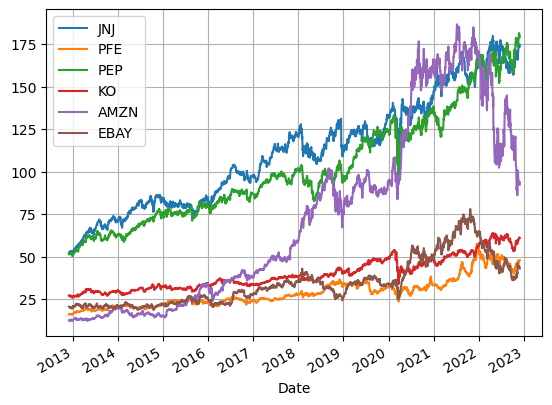

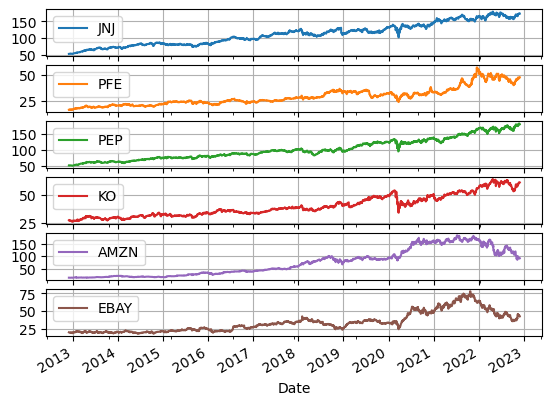

In [4]:
#grafico delle serie
DF_adj.plot(grid = True);
plt.savefig('grafico_delle_serie.png')

#grafico per ogni serie
DF_adj.plot(subplots = True, grid = True)

In [5]:
# rendimento cumulato 
DF_cumulato_Y = round(DF_adj.iloc[-1]/DF_adj.iloc[1] - 1, 3)
DF_cumulato_Y.dropna(inplace = True) #elimino la prima riga dato che ha valore NaN
DF_cumulato_Y

JNJ     2.319
PFE     1.974
PEP     2.488
KO      1.274
AMZN    6.384
EBAY    1.109
dtype: float64

In [6]:
#Aggrego i dati per anno
DF_adj_Y = DF_adj.groupby(pd.Grouper(freq = 'Y')).mean() 

DF_composto_Y = round(pow(DF_adj.iloc[-1]/DF_adj.iloc[1], 1/10) - 1, 3)
DF_composto_Y

JNJ     0.127
PFE     0.115
PEP     0.133
KO      0.086
AMZN    0.221
EBAY    0.077
dtype: float64

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

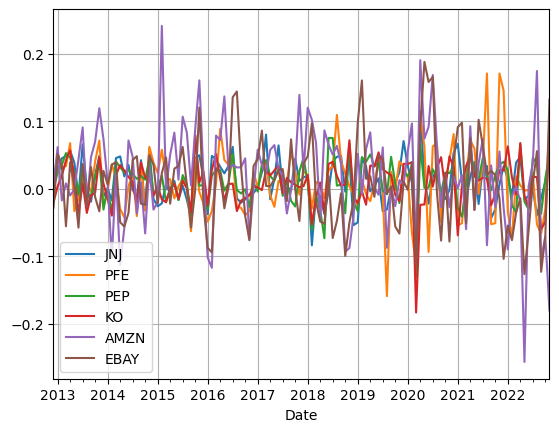

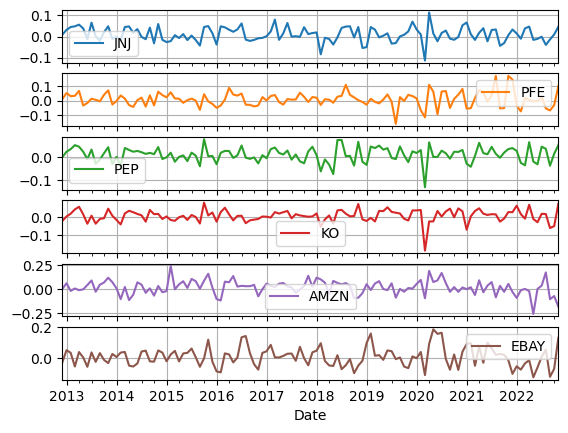

In [7]:
#Aggrego i dati per mesi
DF_adj_M = DF_adj.groupby(pd.Grouper(freq = 'M')).mean() 

DF_semplice_M = DF_adj_M.pct_change() #calcolo il rendimento semplice mensile
DF_semplice_M.dropna(inplace = True) #elimino la prima riga dato che ha valore NaN

DF_semplice_M.plot(grid = True)
DF_semplice_M.plot(subplots = True, grid = True)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

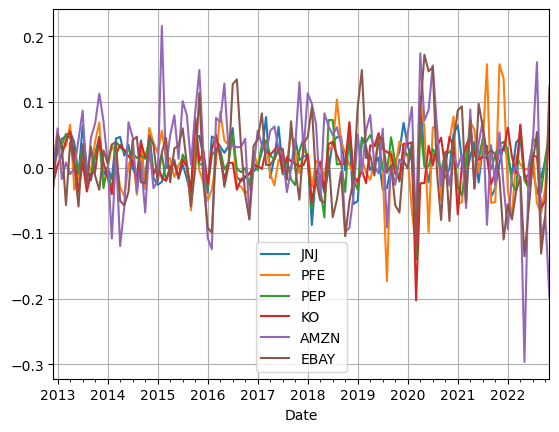

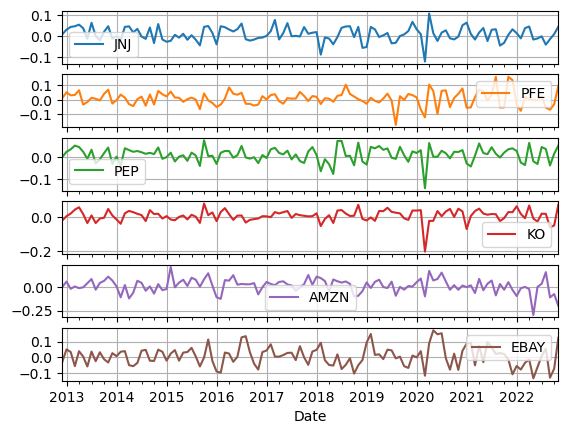

In [8]:
DF_log_M = np.log(DF_adj_M/DF_adj_M.shift(1)) #calcolo il rendimento logaritmico mensile
DF_log_M.dropna(inplace = True) #elimino la prima riga dato che ha valore NaN

DF_log_M.plot(grid = True)
DF_log_M.plot(subplots = True, grid = True)

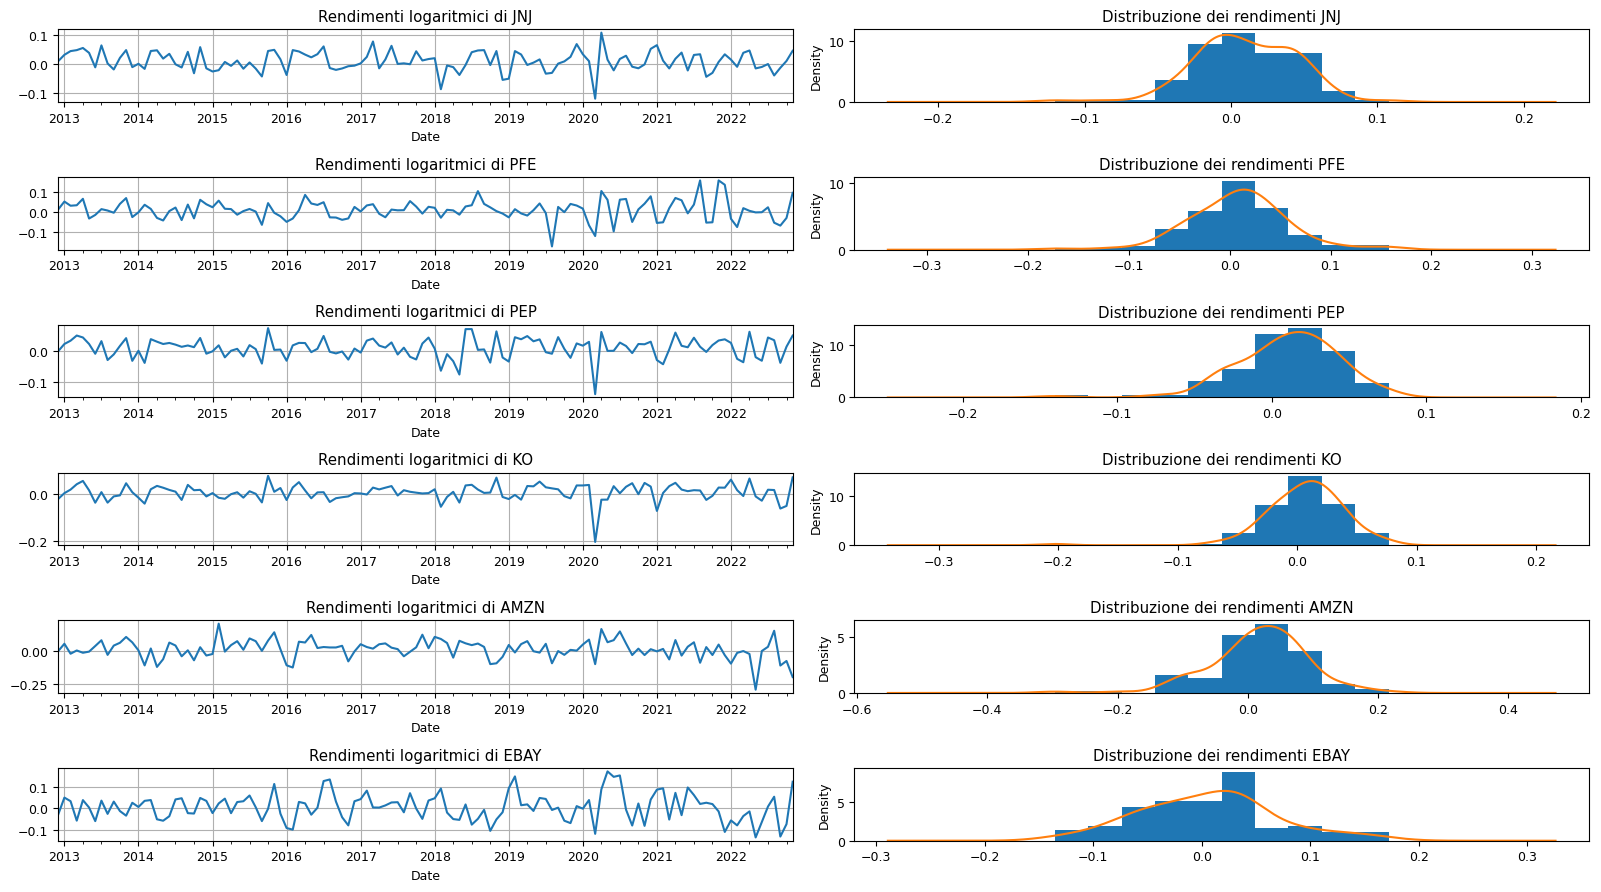

In [11]:
#istogramma e distribuzione rendimento Log

plt.figure(figsize=(16, 9)) #definisco la dimensione dei grafici
plt.rc('font', size=9)

n = 1 #variabile per definire il numero del grafico

def creaGraficoLog(nome): #funzione per creare il grafico del titolo passato come parametro
    global n
    plt.subplot(6, 2, n)
    n = n + 1
    DF_log_M[nome].plot(grid = True, title = 'Rendimenti logaritmici di ' + nome) #grafico dei rendimenti logaritmici
    plt.subplot(6, 2, n)
    n = n + 1
    plt.hist(DF_log_M[nome], density = True) #istogramma dei rendimenti
    plt.title('Distribuzione dei rendimenti ' + nome)
    DF_log_M[nome].plot.density() #verisone continua dell'istogramma
    plt.tight_layout()

#creo i grafici per ogni titolo
creaGraficoLog('JNJ')
creaGraficoLog('PFE')
creaGraficoLog('PEP')
creaGraficoLog('KO')
creaGraficoLog('AMZN')
creaGraficoLog('EBAY')

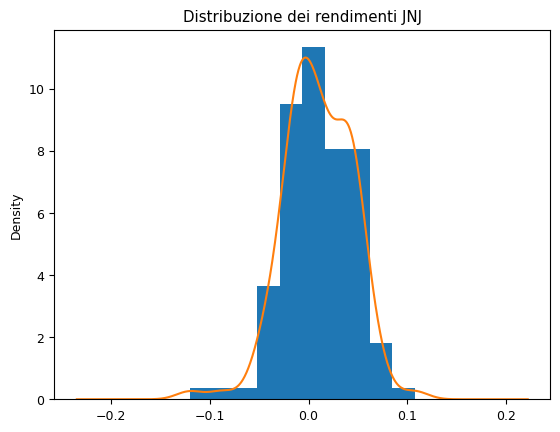

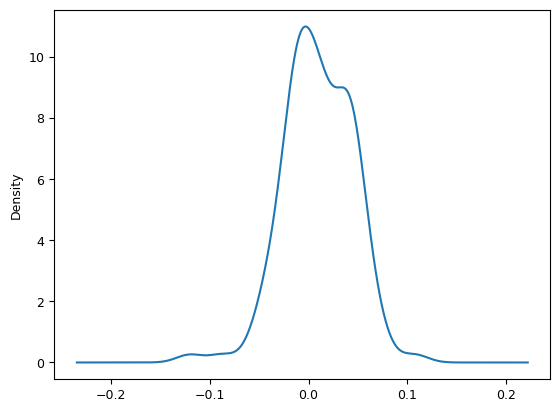

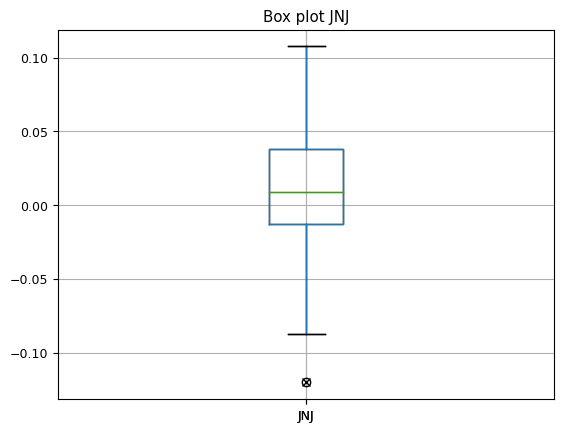

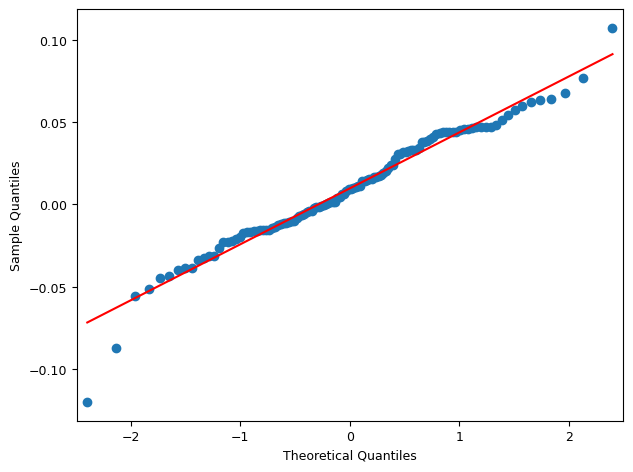

In [12]:
#grafici diagnostici JNJ

#istogramma Log
plt.figure()
plt.hist(DF_log_M['JNJ'], density = True);
DF_log_M['JNJ'].plot.density()
plt.title('Distribuzione dei rendimenti JNJ')

#kernel density Log
plt.figure()
DF_log_M['JNJ'].plot.density();

#boxplot Log
plt.figure()
plt.boxplot(DF_log_M['JNJ'], sym = 'x')
DF_log_M['JNJ'].to_frame().boxplot()
plt.title('Box plot JNJ')

#qq-plot Log
sm.qqplot(DF_log_M['JNJ'], line = 's')


plt.tight_layout()

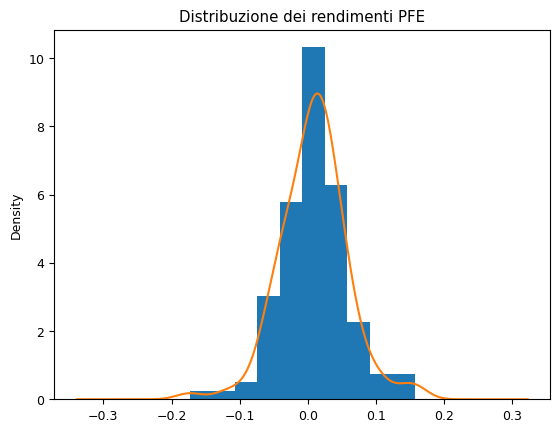

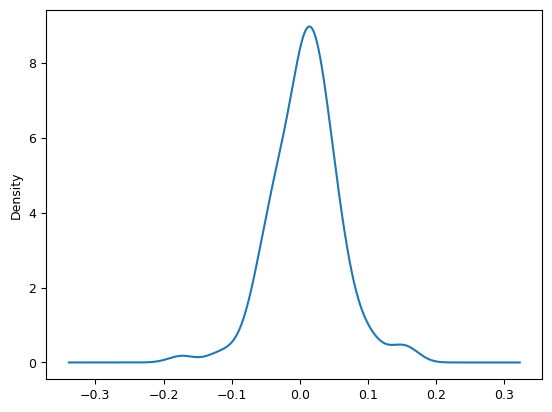

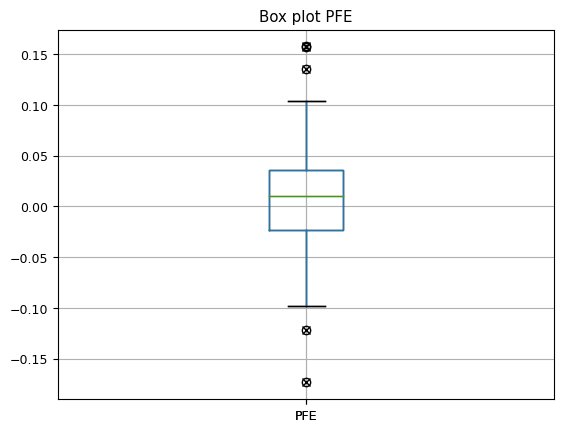

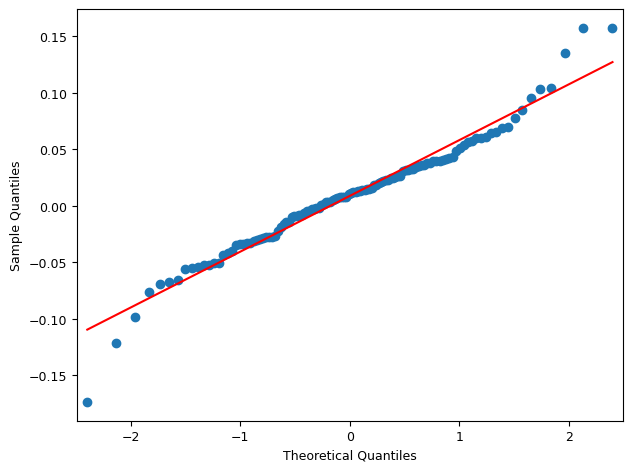

In [13]:
#grafici diagnostici PFE

#istogramma
plt.figure()
plt.hist(DF_log_M['PFE'], density = True);
DF_log_M['PFE'].plot.density()
plt.title('Distribuzione dei rendimenti PFE')

#kernel density
plt.figure()
DF_log_M['PFE'].plot.density();

#boxplot
plt.figure()
plt.boxplot(DF_log_M['PFE'], sym = 'x')
DF_log_M['PFE'].to_frame().boxplot()
plt.title('Box plot PFE')
#qq-plot
sm.qqplot(DF_log_M['PFE'], line = 's')


plt.tight_layout()

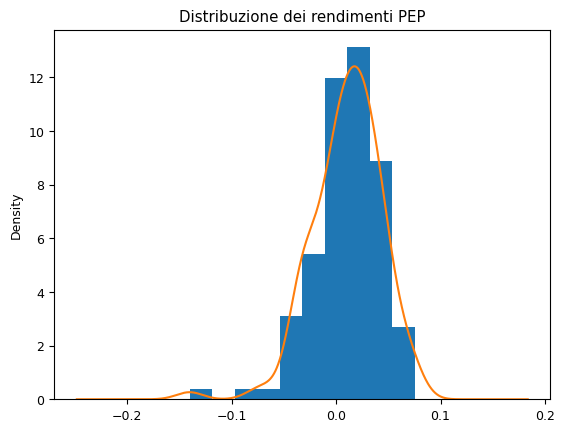

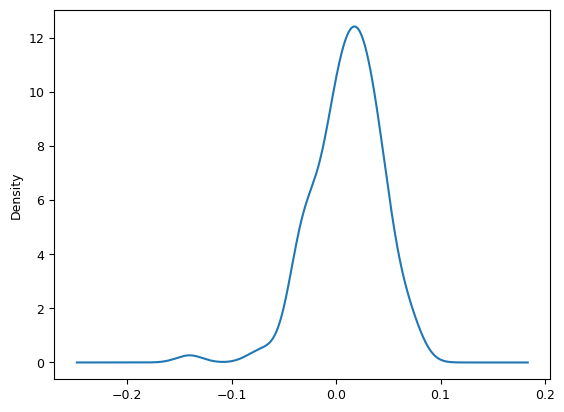

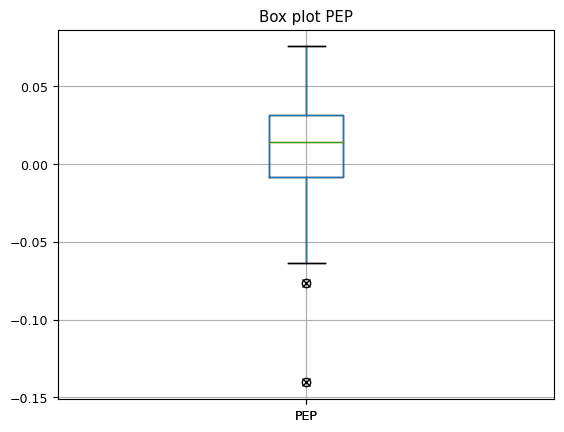

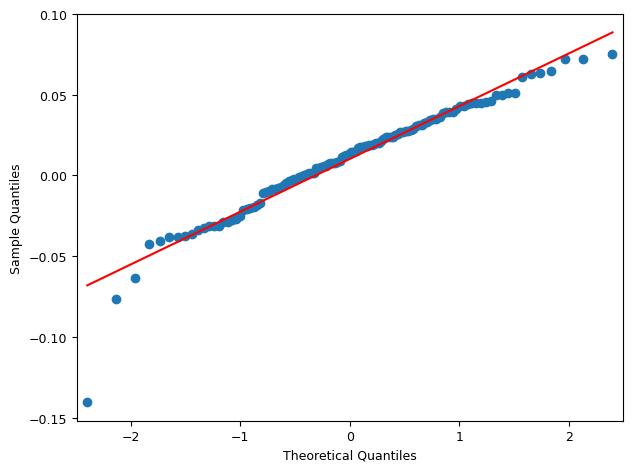

In [14]:
#grafici diagnostici PEP

#istogramma
plt.figure()
plt.hist(DF_log_M['PEP'], density = True);
DF_log_M['PEP'].plot.density()
plt.title('Distribuzione dei rendimenti PEP')

#kernel density
plt.figure()
DF_log_M['PEP'].plot.density();

#boxplot
plt.figure()
plt.boxplot(DF_log_M['PEP'], sym = 'x')
DF_log_M['PEP'].to_frame().boxplot()
plt.title('Box plot PEP')
#qq-plot
sm.qqplot(DF_log_M['PEP'], line = 's')


plt.tight_layout()

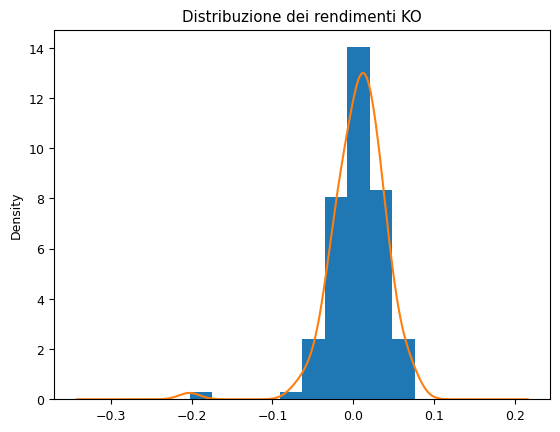

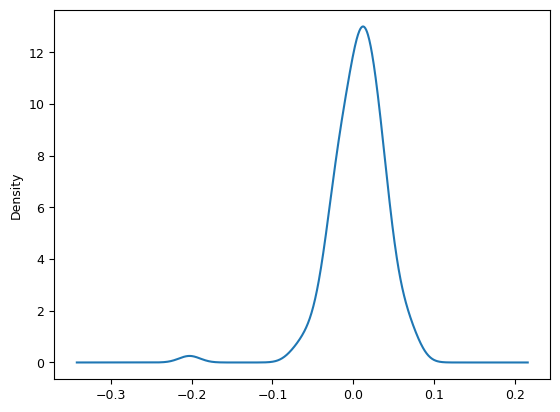

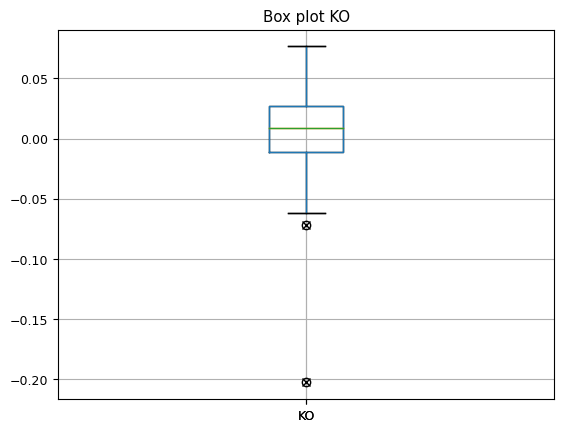

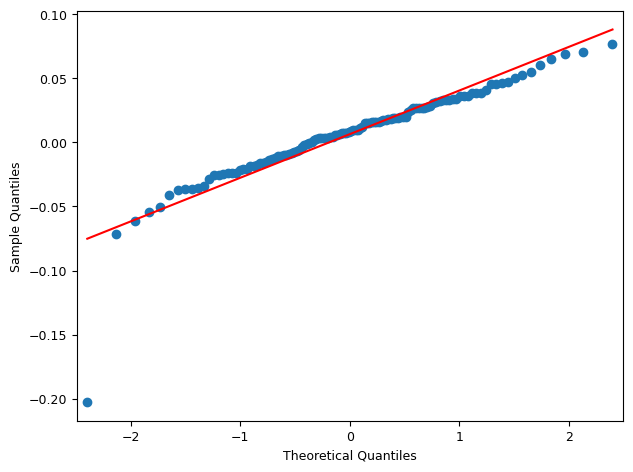

In [15]:
#grafici diagnostici KO

#istogramma
plt.figure()
plt.hist(DF_log_M['KO'], density = True);
DF_log_M['KO'].plot.density()
plt.title('Distribuzione dei rendimenti KO')

#kernel density
plt.figure()
DF_log_M['KO'].plot.density();

#boxplot
plt.figure()
plt.boxplot(DF_log_M['KO'], sym = 'x')
DF_log_M['KO'].to_frame().boxplot()
plt.title('Box plot KO')

#qq-plot
sm.qqplot(DF_log_M['KO'], line = 's')

plt.tight_layout()

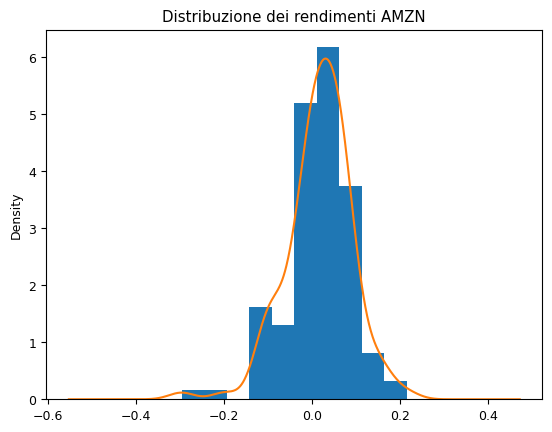

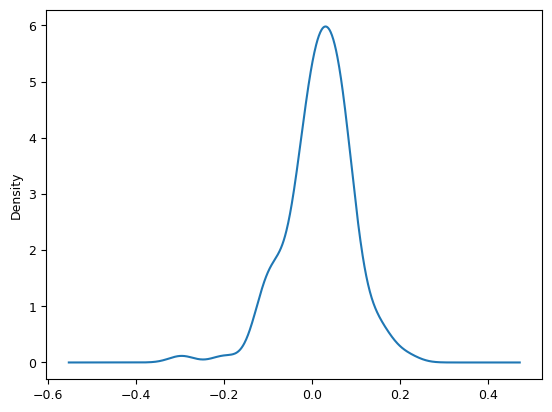

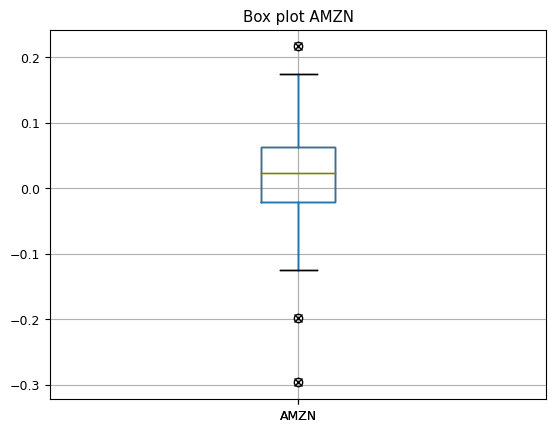

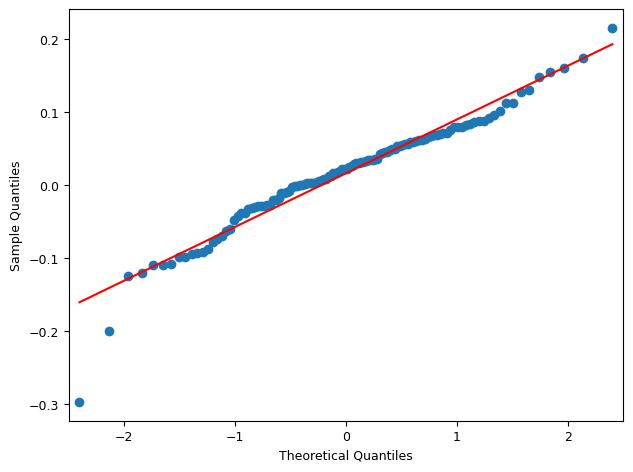

In [16]:
#grafici diagnostici AMZN

#istogramma
plt.figure()
plt.hist(DF_log_M['AMZN'], density = True);
DF_log_M['AMZN'].plot.density()
plt.title('Distribuzione dei rendimenti AMZN')

#kernel density
plt.figure()
DF_log_M['AMZN'].plot.density();

#boxplot
plt.figure()
plt.boxplot(DF_log_M['AMZN'], sym = 'x')
DF_log_M['AMZN'].to_frame().boxplot()
plt.title('Box plot AMZN')

#qq-plot
sm.qqplot(DF_log_M['AMZN'], line = 's')


plt.tight_layout()

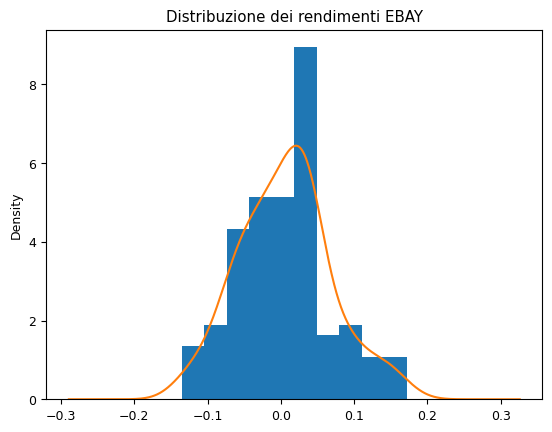

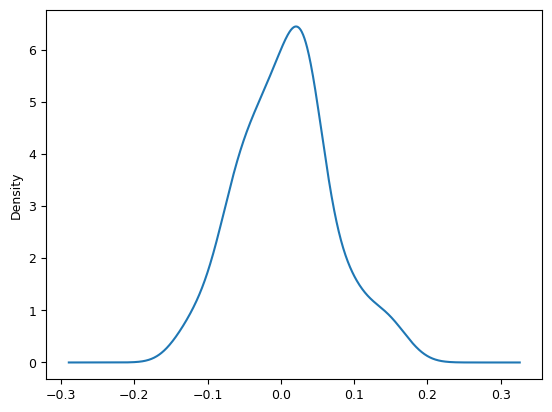

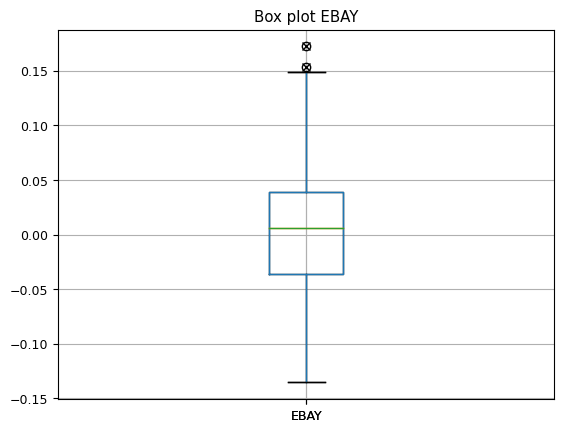

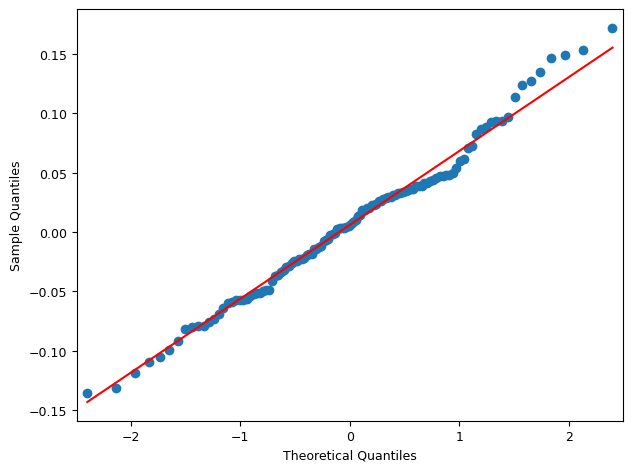

In [17]:
#grafici diagnostici EBAY

#istogramma
plt.figure()
plt.hist(DF_log_M['EBAY'], density = True);
DF_log_M['EBAY'].plot.density()
plt.title('Distribuzione dei rendimenti EBAY')

#kernel density
plt.figure()
DF_log_M['EBAY'].plot.density();

#boxplot
plt.figure()
plt.boxplot(DF_log_M['EBAY'], sym = 'x')
DF_log_M['EBAY'].to_frame().boxplot()
plt.title('Box plot EBAY')

#qq-plot
sm.qqplot(DF_log_M['EBAY'], line = 's')


plt.tight_layout()

In [18]:
#media
def media(nome):
    print("La media del rendimento logaritmico di " + nome + " è " + str(round(DF_log_M[nome].mean(), 4)))
    print("\n")

media('JNJ')
media('PFE')
media('PEP')
media('KO')
media('AMZN')
media('EBAY')

La media del rendimento logaritmico di JNJ è 0.0098


La media del rendimento logaritmico di PFE è 0.0089


La media del rendimento logaritmico di PEP è 0.0103


La media del rendimento logaritmico di KO è 0.0065


La media del rendimento logaritmico di AMZN è 0.0167


La media del rendimento logaritmico di EBAY è 0.006




In [19]:
#varianza
def varianza(nome):
    print("La varianza del rendimento logaritmico di " + nome + " è " + str(round(DF_log_M[nome].var(), 4)))
    print("\n")

varianza('JNJ')
varianza('PFE')
varianza('PEP')
varianza('KO')
varianza('AMZN')
varianza('EBAY')

La varianza del rendimento logaritmico di JNJ è 0.0012


La varianza del rendimento logaritmico di PFE è 0.0025


La varianza del rendimento logaritmico di PEP è 0.0011


La varianza del rendimento logaritmico di KO è 0.0012


La varianza del rendimento logaritmico di AMZN è 0.0055


La varianza del rendimento logaritmico di EBAY è 0.0039




In [20]:
#deviazione standard
def std(nome):
    print("La deviazione standard del rendimento logaritmico di " + nome + " è " + str(round(DF_log_M[nome].std(), 4)))
    print("\n")

std('JNJ')
std('PFE')
std('PEP')
std('KO')
std('AMZN')
std('EBAY')

La deviazione standard del rendimento logaritmico di JNJ è 0.0342


La deviazione standard del rendimento logaritmico di PFE è 0.0496


La deviazione standard del rendimento logaritmico di PEP è 0.0328


La deviazione standard del rendimento logaritmico di KO è 0.0342


La deviazione standard del rendimento logaritmico di AMZN è 0.074


La deviazione standard del rendimento logaritmico di EBAY è 0.0625




In [21]:
#asimmetria
def skew(nome):
    print("L'assimetria del rendimento logaritmico di " + nome + " è " + str(round(DF_log_M[nome].skew(), 4)))
    print("\n")
    

skew('JNJ')
skew('PFE')
skew('PEP')
skew('KO')
skew('AMZN')
skew('EBAY')

L'assimetria del rendimento logaritmico di JNJ è -0.3872


L'assimetria del rendimento logaritmico di PFE è -0.0414


L'assimetria del rendimento logaritmico di PEP è -0.9266


L'assimetria del rendimento logaritmico di KO è -1.9287


L'assimetria del rendimento logaritmico di AMZN è -0.7235


L'assimetria del rendimento logaritmico di EBAY è 0.2163




In [22]:
#kurtosi
def kurtosis(nome):
    print("La kurtosi del rendimento logaritmico di " + nome + " è " + str(round(DF_log_M[nome].kurtosis(), 4)))
    print("\n")
    
kurtosis('JNJ')
kurtosis('PFE')
kurtosis('PEP')
kurtosis('KO')
kurtosis('AMZN')
kurtosis('EBAY')

La kurtosi del rendimento logaritmico di JNJ è 1.2309


La kurtosi del rendimento logaritmico di PFE è 1.9714


La kurtosi del rendimento logaritmico di PEP è 2.8437


La kurtosi del rendimento logaritmico di KO è 10.7571


La kurtosi del rendimento logaritmico di AMZN è 2.4297


La kurtosi del rendimento logaritmico di EBAY è 0.0509




In [23]:
#matrice varianze/covarianze
DF_log_M.cov()

JNJ       PFE       PEP        KO      AMZN      EBAY
JNJ   0.001172  0.000891  0.000706  0.000589  0.000312  0.000311
PFE   0.000891  0.002457  0.000723  0.000558  0.000661  0.000479
PEP   0.000706  0.000723  0.001077  0.000819  0.000535  0.000477
KO    0.000589  0.000558  0.000819  0.001171  0.000136  0.000162
AMZN  0.000312  0.000661  0.000535  0.000136  0.005482  0.002109
EBAY  0.000311  0.000479  0.000477  0.000162  0.002109  0.003911

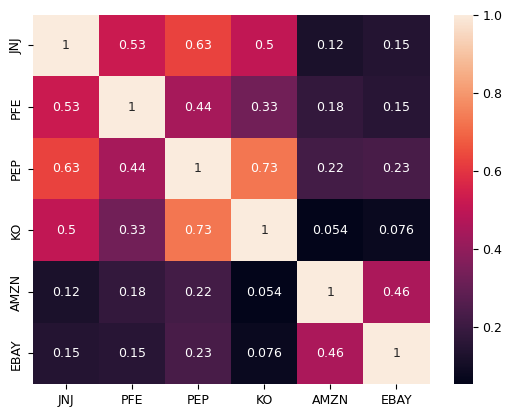

In [24]:
#matrice di correlazione (DA CAMBIARE COLORE MATRICE)
corr_matrix = DF_log_M.corr()
heatmap = sns.heatmap(corr_matrix, annot=True)

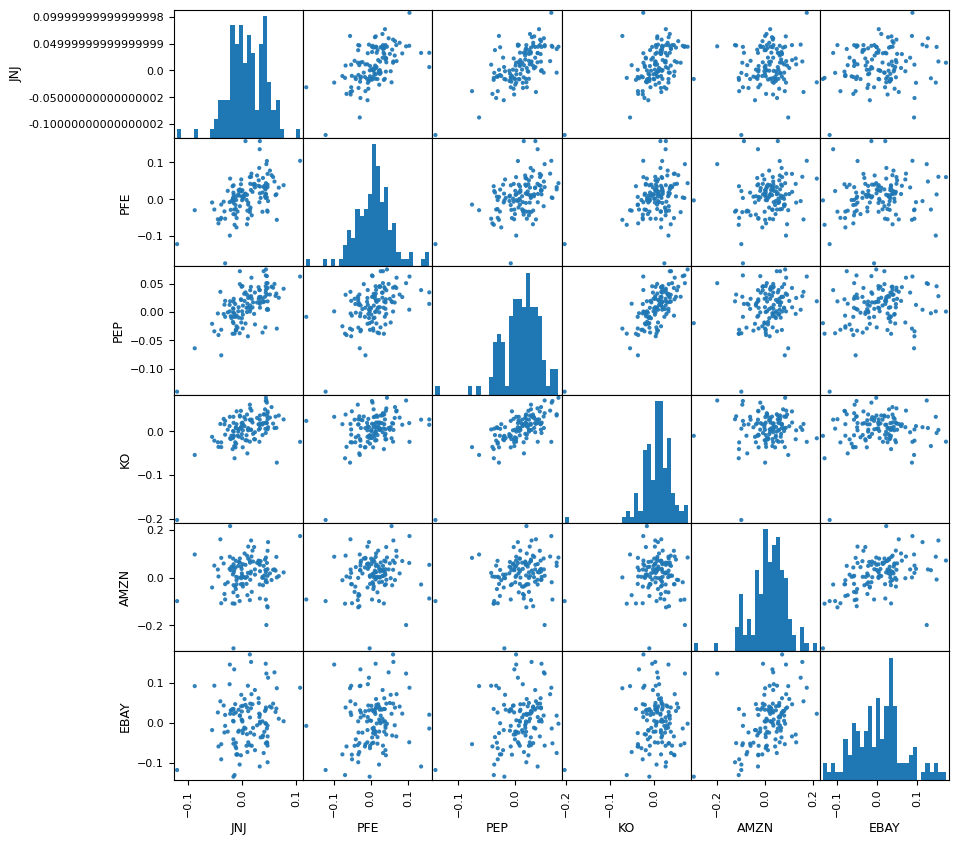

In [25]:
pd.plotting.scatter_matrix(DF_log_M, alpha = 0.92,
                          diagonal = 'hist',
                          hist_kwds = {'bins':30},
                          figsize = (10, 10), grid = True);


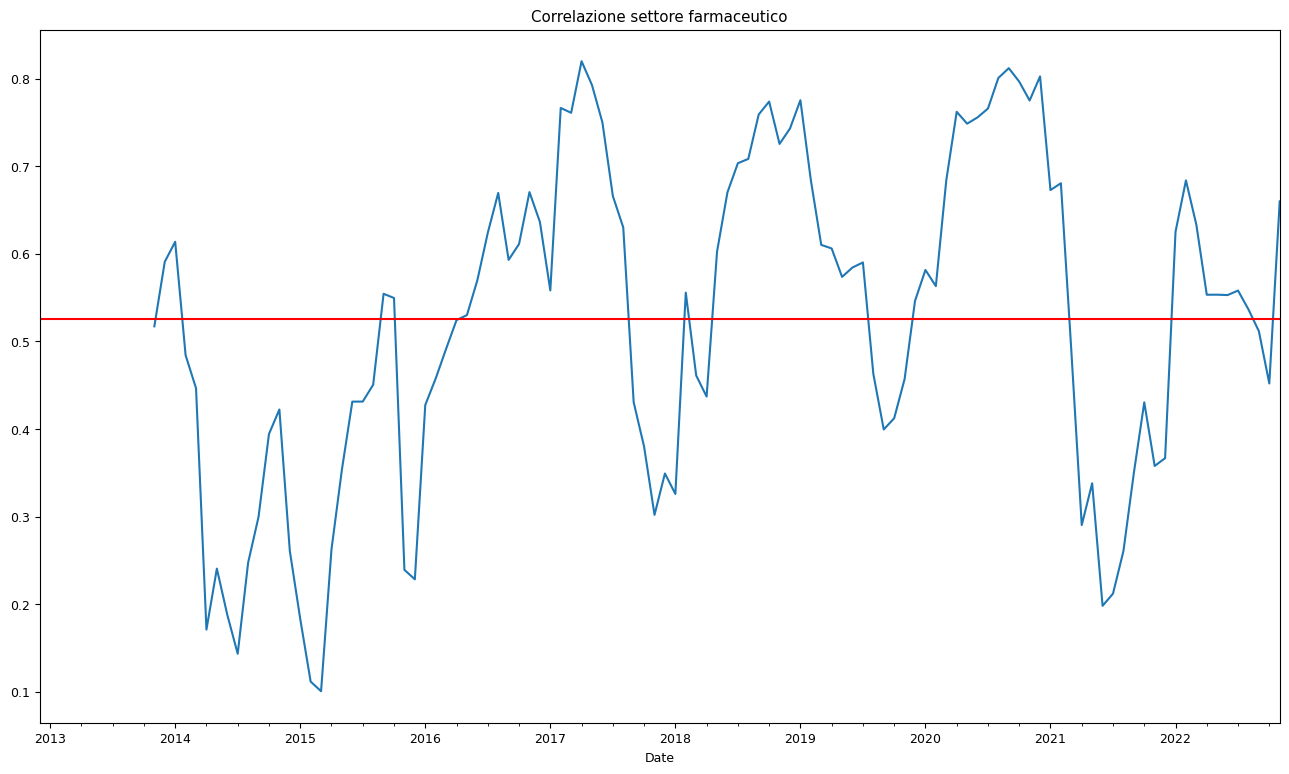

In [26]:
gx = DF_log_M['JNJ'].rolling(window=12).corr(DF_log_M['PFE']).plot(figsize = (16, 9))
gx.axhline(DF_log_M.corr().iloc[0, 1], c='r')
plt.title('Correlazione settore farmaceutico')
plt.savefig('corr nel tempo settore 1.png')

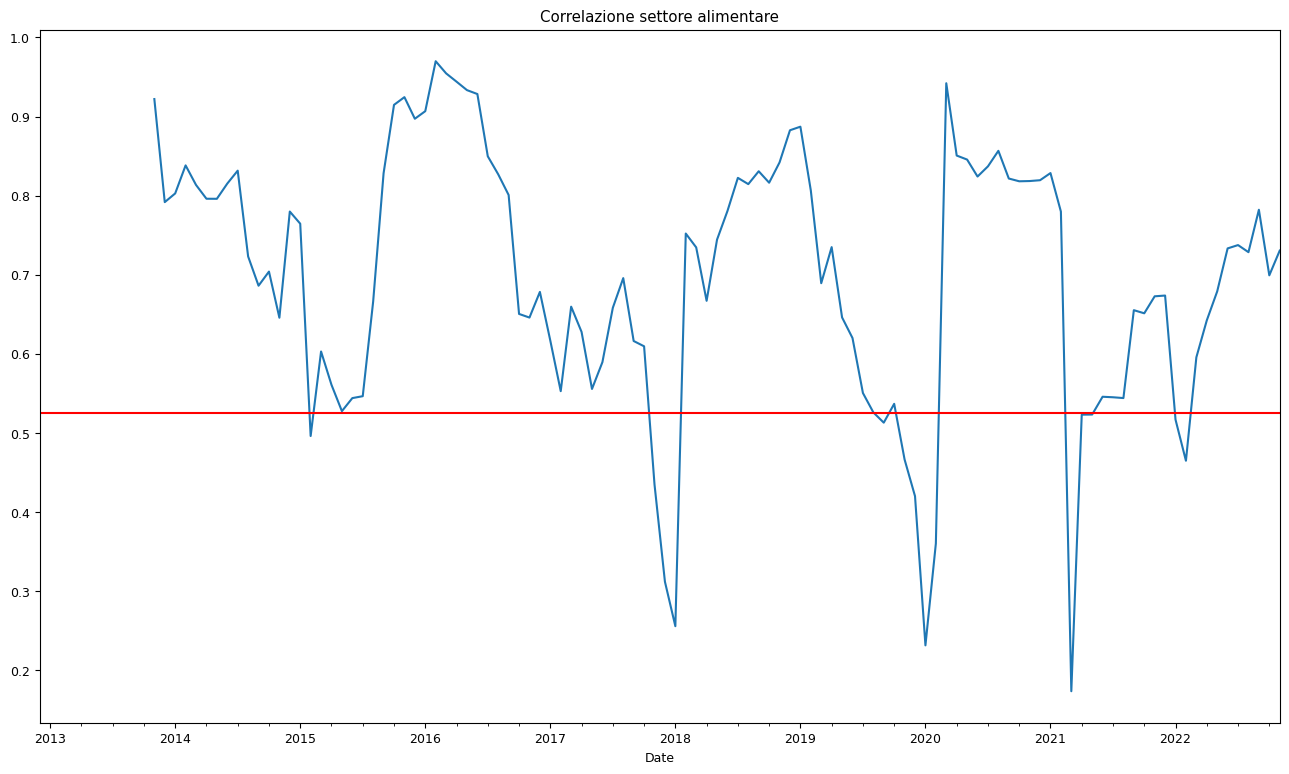

In [27]:
gx = DF_log_M['PEP'].rolling(window=12).corr(DF_log_M['KO']).plot(figsize = (16, 9))
gx.axhline(DF_log_M.corr().iloc[0, 1], c='r')
plt.title('Correlazione settore alimentare')
plt.savefig('corr nel tempo settore 2.png')

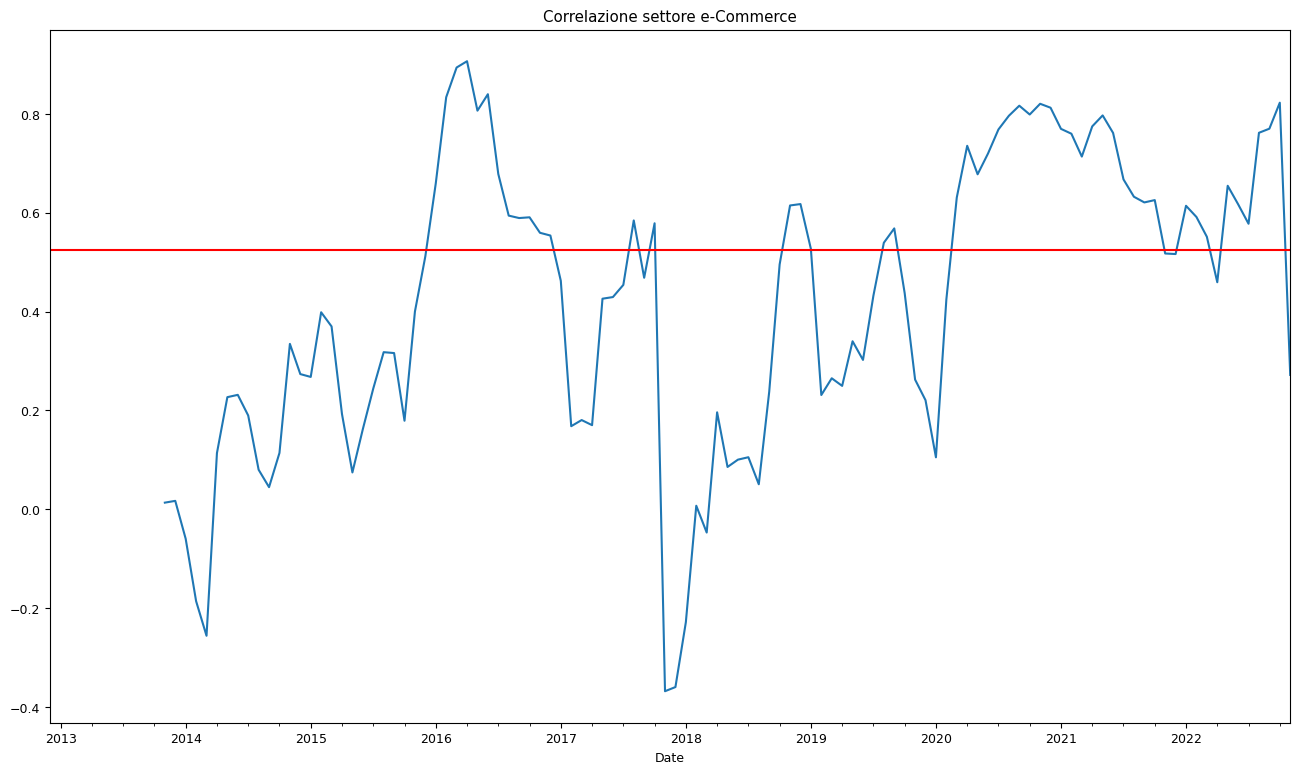

In [28]:
gx = DF_log_M['AMZN'].rolling(window=12).corr(DF_log_M['EBAY']).plot(figsize = (16, 9))
gx.axhline(DF_log_M.corr().iloc[0, 1], c='r')
plt.title('Correlazione settore e-Commerce')
plt.savefig('corr nel tempo settore 3.png')

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2066215949.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['Prediction'], 1))


confidenza della previsione di JNJ:  0.8854111066235578
errore medio di JNJ:  11.807910749754454
confidenza della previsione di PFE:  0.608222584083808
errore medio di PFE:  2.92094862518325
confidenza della previsione di PEP:  0.9471473819546401
errore medio di PEP:  16.549966201696137
confidenza della previsione di KO:  0.8118698682137028
errore medio di KO:  5.347123540592371
confidenza della previsione di AMZN:  0.7261197459141074
errore medio di AMZN:  5.287871321761286
confidenza della previsione di EBAY:  0.6052625226931253
errore medio di EBAY:  2.5075865762173564


C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2066215949.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_forecast = df.drop(['Prediction'],1)[-forecast_out:] #selezioni gli ultimi 10 mesi
C:\Users\loren\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2066215949.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['Prediction'], 1))
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2066215949.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_forecast = df.drop(['Prediction'],1)[-forecast_out:] #selezioni gli ultimi 10 mesi
C:\Users\loren

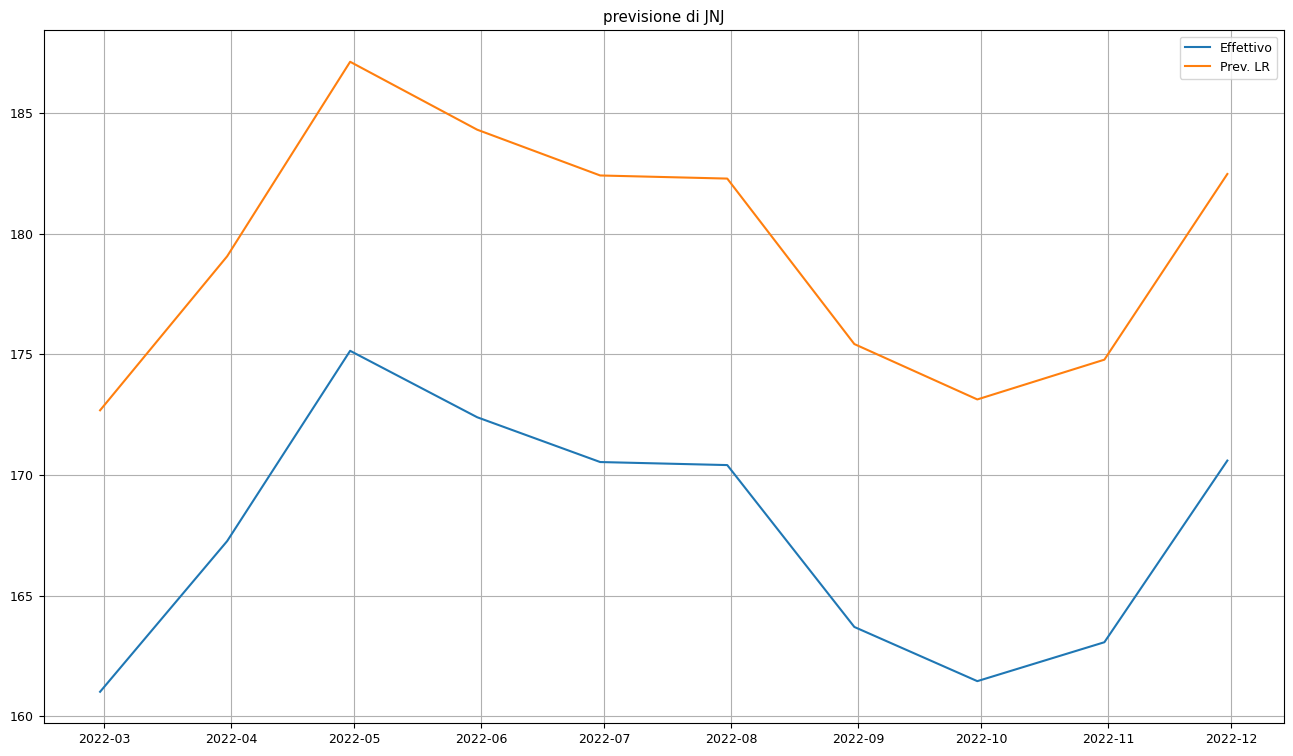

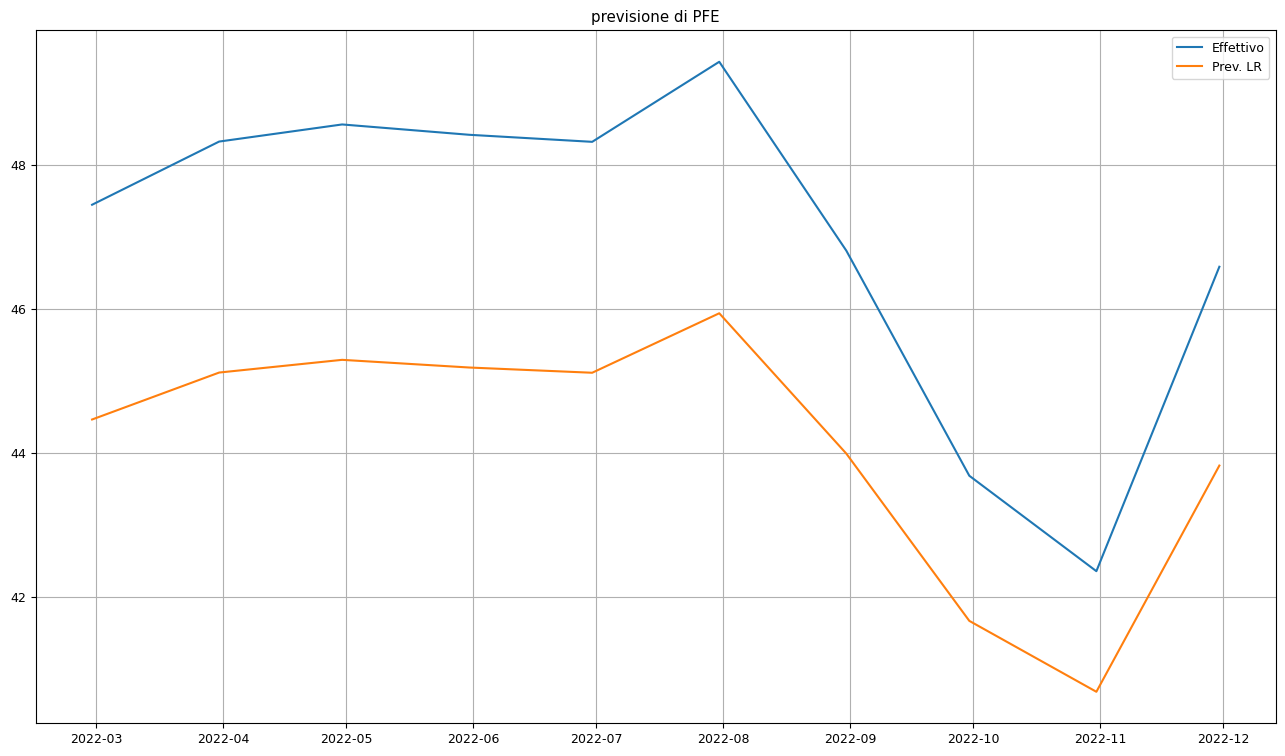

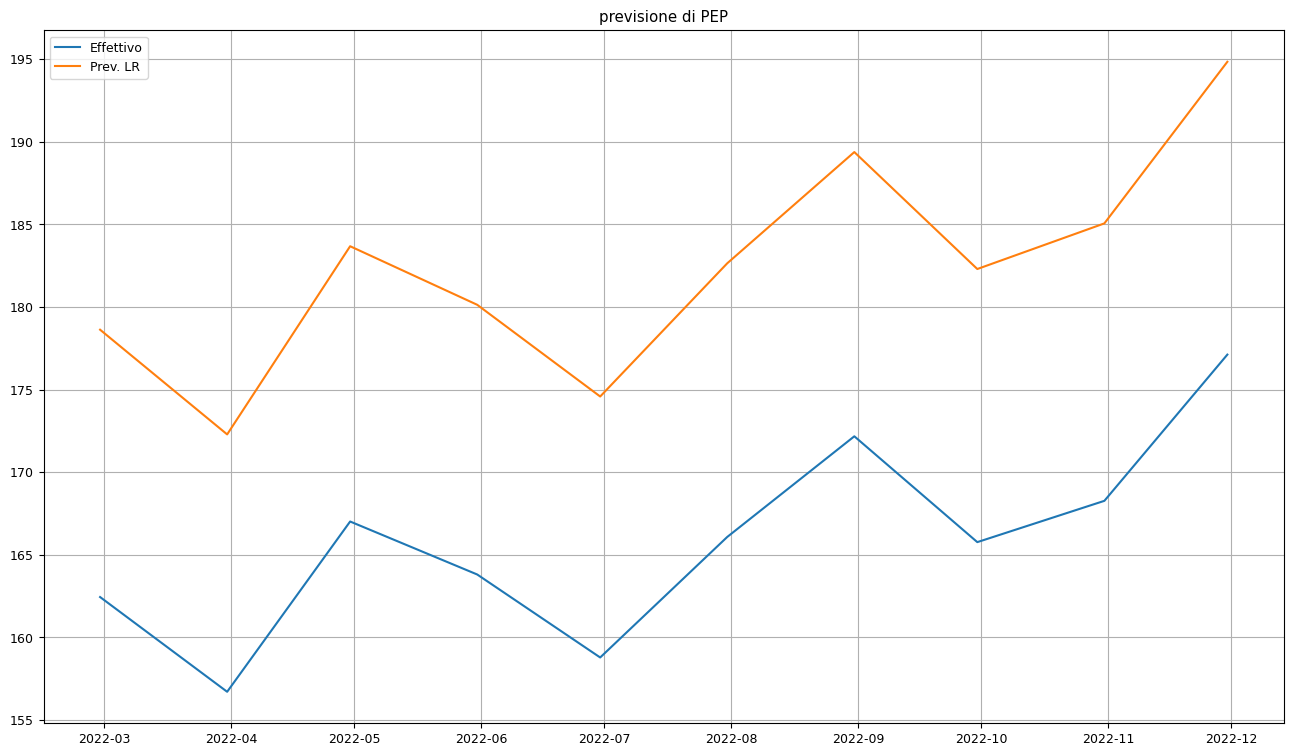

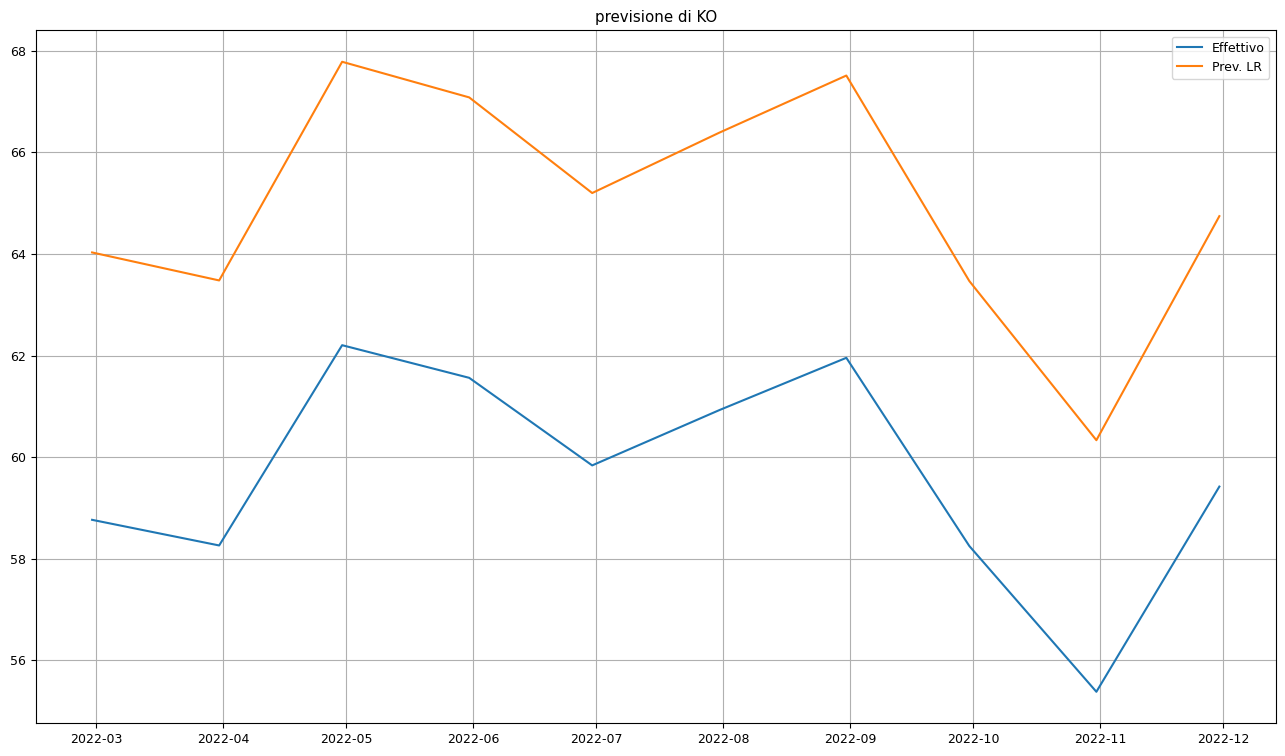

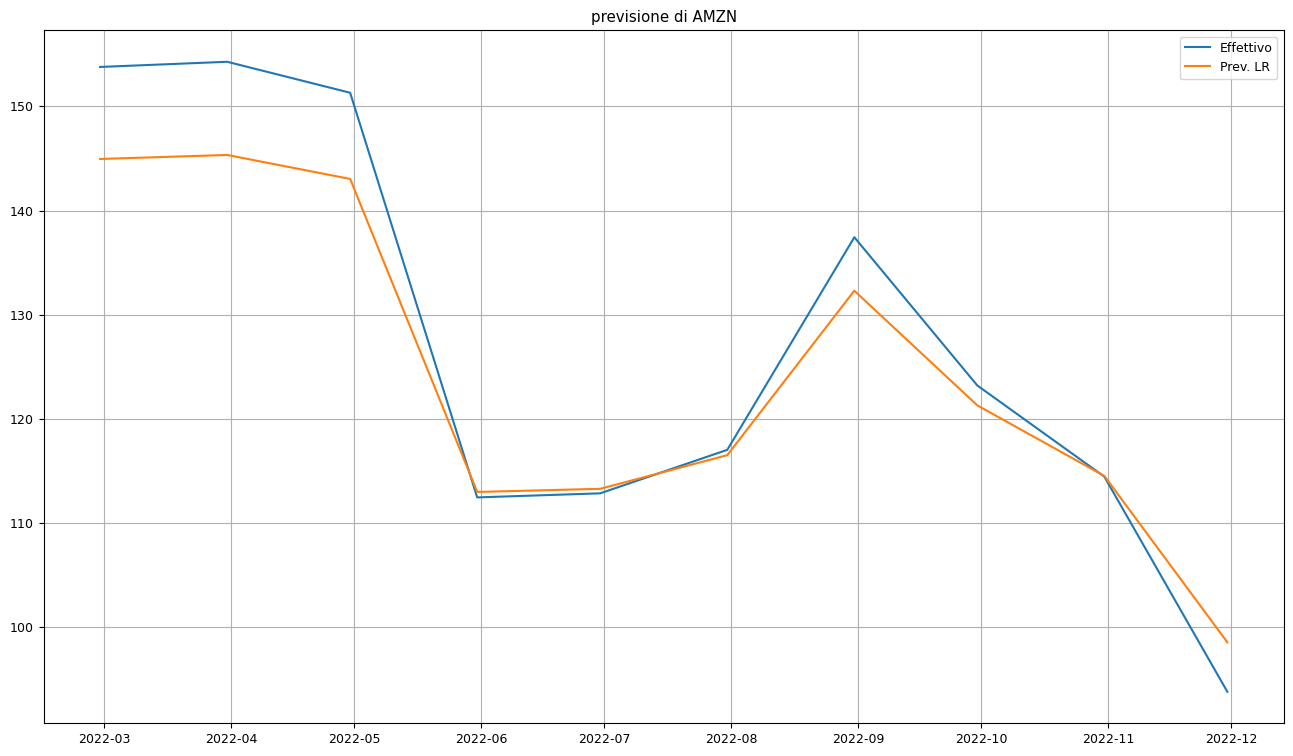

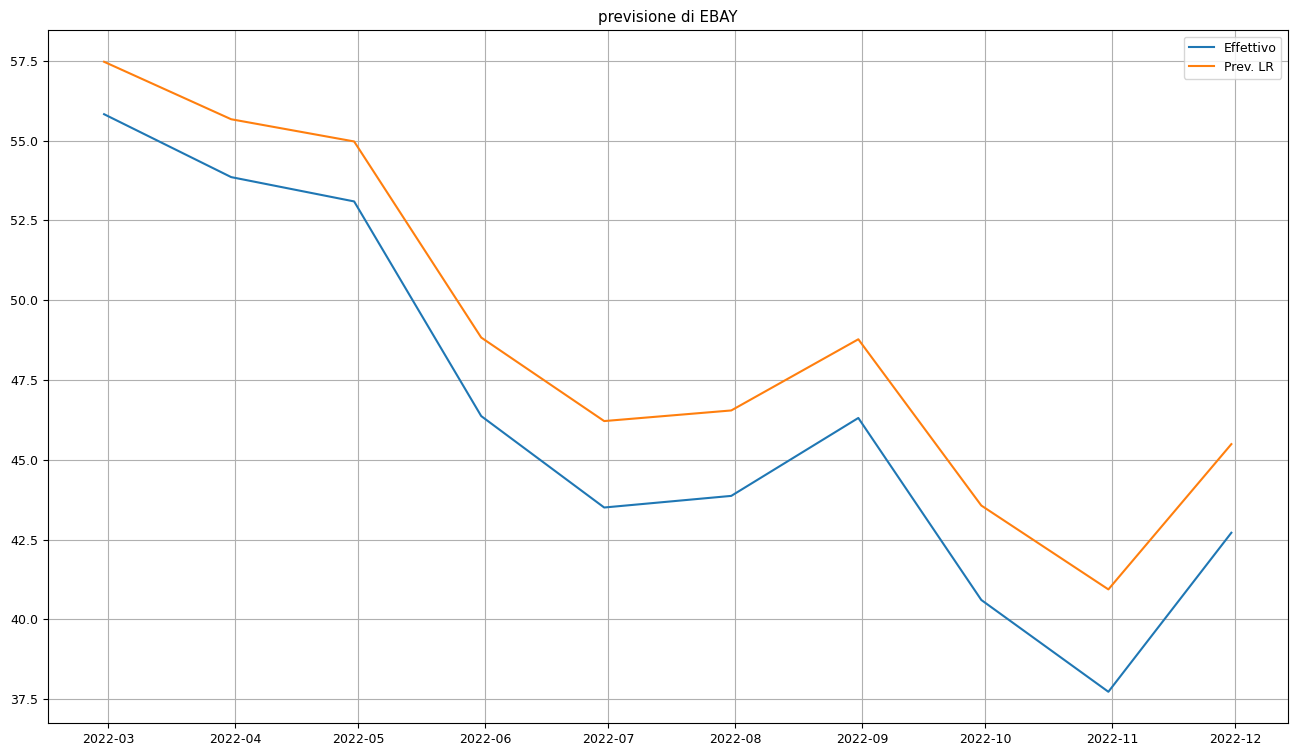

In [29]:
#modello di previsione LR

forecast_out = 10


def LR(nome):
    df = pd.DataFrame(DF_adj_M[nome]) #credo il dataframe con solo la colonna Adj Close
    df['Prediction'] = df[nome].shift(-forecast_out) #creo la colonna prediction
    
    # Creiamo un data set indipendente (X), trasformando il df in un array
    X = np.array(df.drop(['Prediction'], 1))
    
    # Eliminiamo le ultime 110 righe
    X = X[:-forecast_out]
    
    # Creiamo il data set dipendente (y)
    y = np.array(df['Prediction'])
    y = y[:-forecast_out] #elimini gli elementi NaN

    # Creo i train e test set
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.66)
    
    #creo e addestro un modello di regressione lineare
    lr = LinearRegression() #creo il modello
    lr.fit(x_test, y_test) #addestro il modello
    lr_confindence = lr.score(x_test, y_test)
    print('confidenza della previsione di ' + nome + ': ', lr_confindence)
    
    #creo la previsione degli ultimi 10 mesi
    x_forecast = df.drop(['Prediction'],1)[-forecast_out:] #selezioni gli ultimi 10 mesi
    
    x_forecast[nome] = lr.predict(x_forecast) #creo la previsione degli ultimi 10 mesi)
    
    lr_rmse = sqrt(mean_squared_error(df[nome][-forecast_out:], x_forecast[nome]))
    print('errore medio di ' + nome + ': ', lr_rmse)

    plt.figure(figsize=(16,9))
    plt.title("previsione di " + nome)
    plt.plot(DF_adj_M[nome].iloc[-forecast_out:], label = 'Effettivo')
    plt.plot(x_forecast[nome], label = 'Prev. LR')
    plt.grid(True)
    plt.legend()
    
    
    

LR('JNJ')
LR('PFE')
LR('PEP')
LR('KO')
LR('AMZN')
LR('EBAY')


In [30]:
# faccio la previsione con la strategia sma e ewm

def sma(nome):

    # seleziono la colonna Adj close eliminando le altre
    adj = nome.drop(columns = ['High', 'Low', 'Open', 'Close'])

    # aggiungo due colonne che rappresentano rispettivamente la media ogni 20 e 120 giorni
    adj['M20'] = adj['Adj Close'].rolling(20).mean()
    adj['M120'] = adj['Adj Close'].rolling(120).mean()

    # creo la strategia
    adj['Price Yesterday'] = adj['Adj Close'].shift(1) # creo la colonna con il prezzo del giorno prima
    adj['Change'] = adj['Adj Close'] / adj['Price Yesterday'] # creo la colonna con la variazione di prezzo tra un 
                                                                         # giorno e il successivo

    adj['Invested'] = [1 if adj.loc[i, 'M20'] > adj.loc[i, 'M120'] # creo la colonna dove ci sarà uno se la media
                        else 0 for i in adj.index]                       # a 20 giorni è maggiore di quella a 120,
                                                                              # altrimenti 0
                
    sma = adj[adj['Invested'] == 1] # seleziono i soli valori uguali a 1
    sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
    
    adj['EWM12'] = adj['Adj Close'].ewm(span=12, adjust=False).mean()
    adj['EWM26'] = adj['Adj Close'].ewm(span=25, adjust=False).mean()
    
    adj['Invested_EWM'] = [1 if adj.loc[i, 'EWM12'] > adj.loc[i, 'EWM26'] 
                        else 0 for i in adj.index]
    ewm = adj[adj['Invested_EWM'] == 1]
    ewm['Return'] = np.cumprod(ewm['Change'])

    # confronto la strategia sma con la strategia del Buy & Hold
    adj['B&H'] = np.cumprod(adj['Change']) # rendimento del B&H
    
    #grafico delle due medie
    
    plt.figure(figsize=(16,9))
    plt.plot(adj['M20'], label = 'M20')    
    plt.plot(adj['M120'], label = 'M120')
    plt.plot(adj['EWM12'], label = 'EWM12')
    plt.plot(adj['EWM26'], label = 'EWM26')
    plt.grid(True)
    plt.legend();
    plt.savefig('Grafico medie.png')
    #confronto grafico

    plt.figure(figsize=(16,9))
    plt.plot(adj['B&H'], label = 'B&H')
    plt.plot(sma['Return'], label = 'SMA')
    plt.plot(ewm['Return'], label ='EWM')
    plt.grid(True)
    plt.legend();
    print('Buy & Hold strategy return = ' + str(adj['B&H'][-1]))
    print('SMA return = ' + str(sma['Return'][-1]))
    print('EWM return = ' + str(ewm['Return'][-1]))
    plt.savefig('Grafico mconfronto strategie.png')


C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 3.3153670171939447
SMA return = 1.3720086507331346
EWM return = 3.0900444505585045


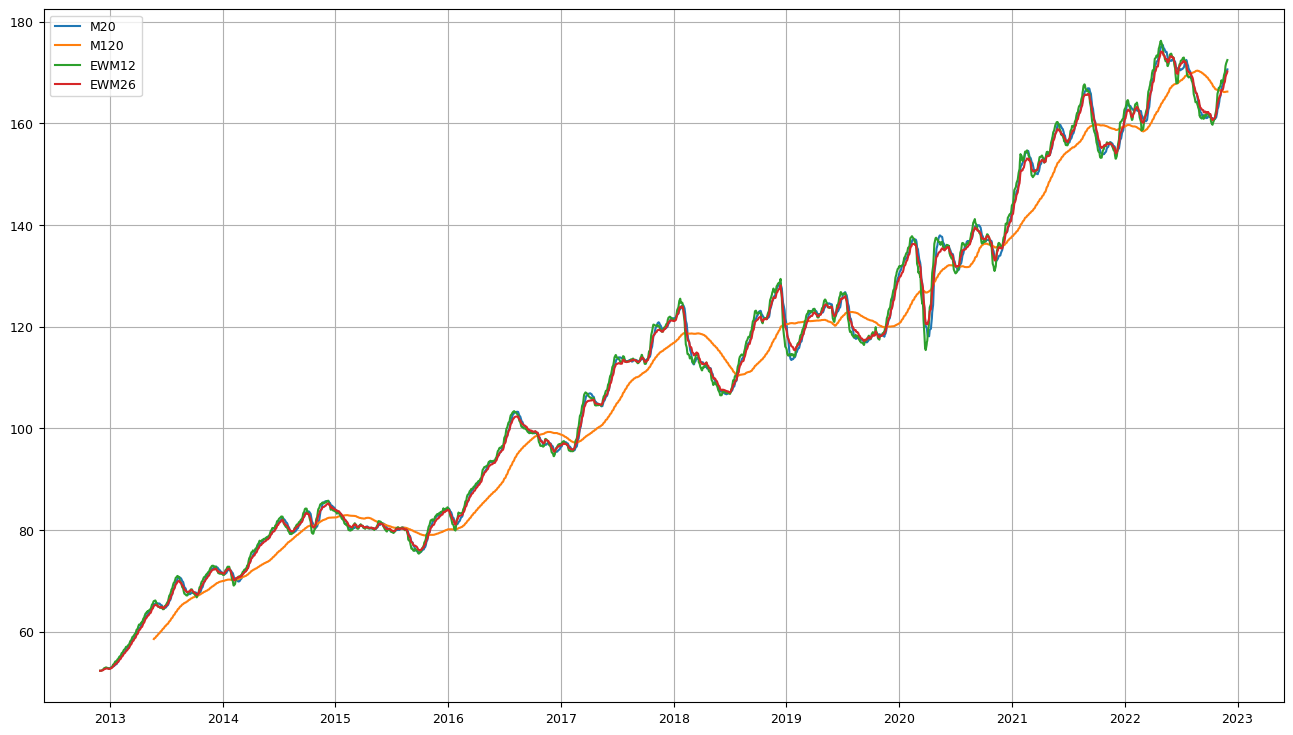

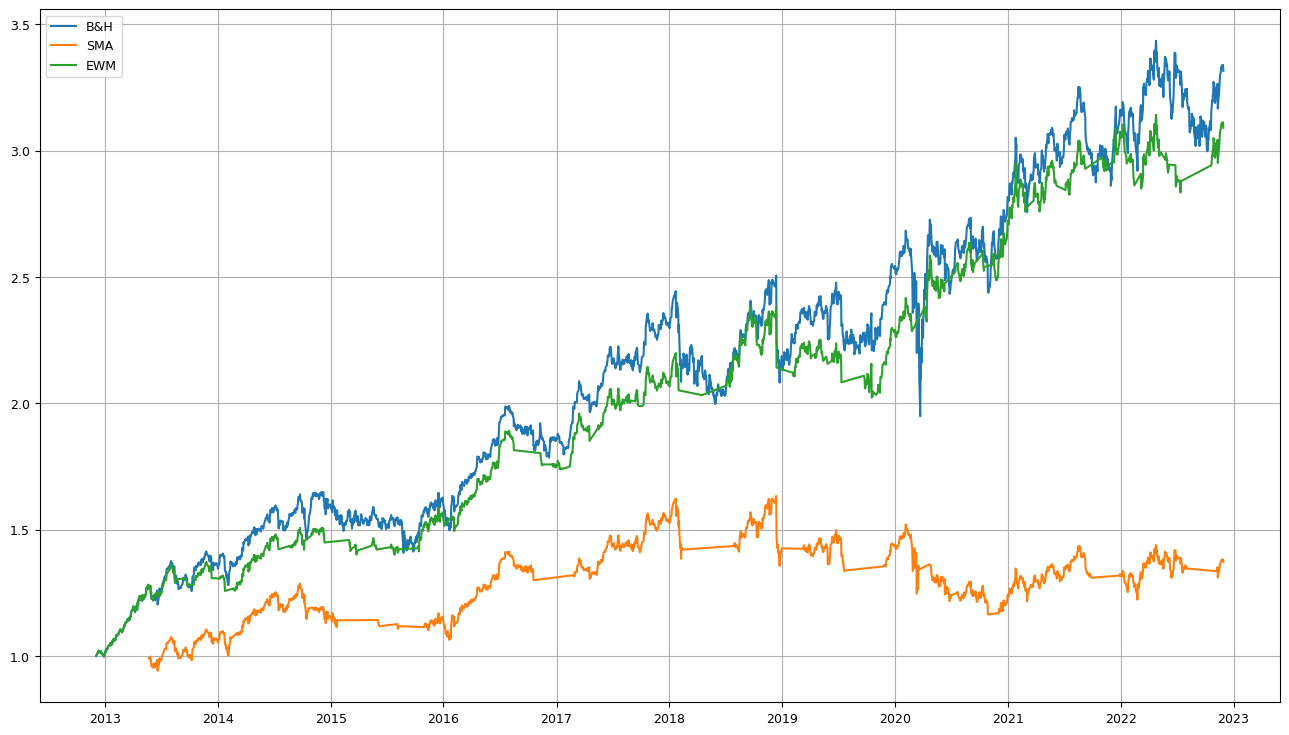

In [31]:
sma(JNJ)

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 2.982019550677234
SMA return = 0.9212470394101695
EWM return = 3.934336167847472


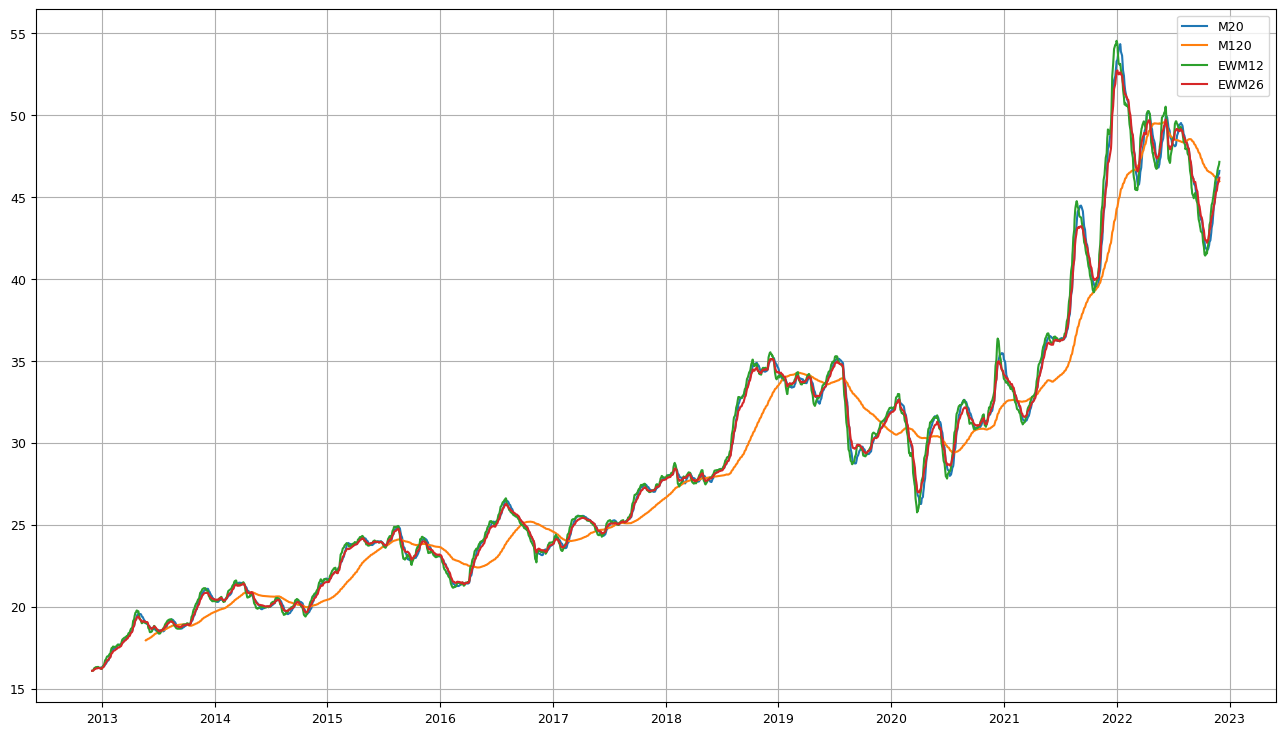

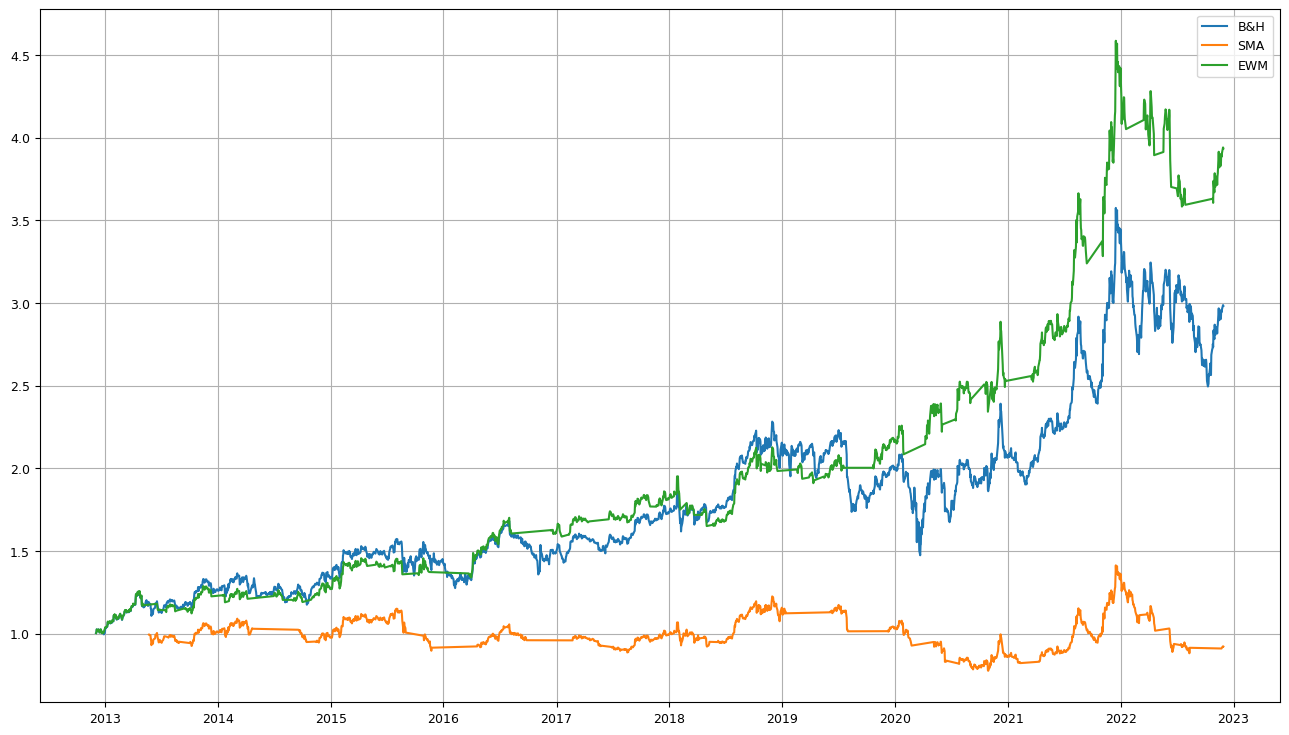

In [32]:
sma(PFE)

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 3.4714524442429355
SMA return = 1.3820395966530696
EWM return = 3.371295395487374


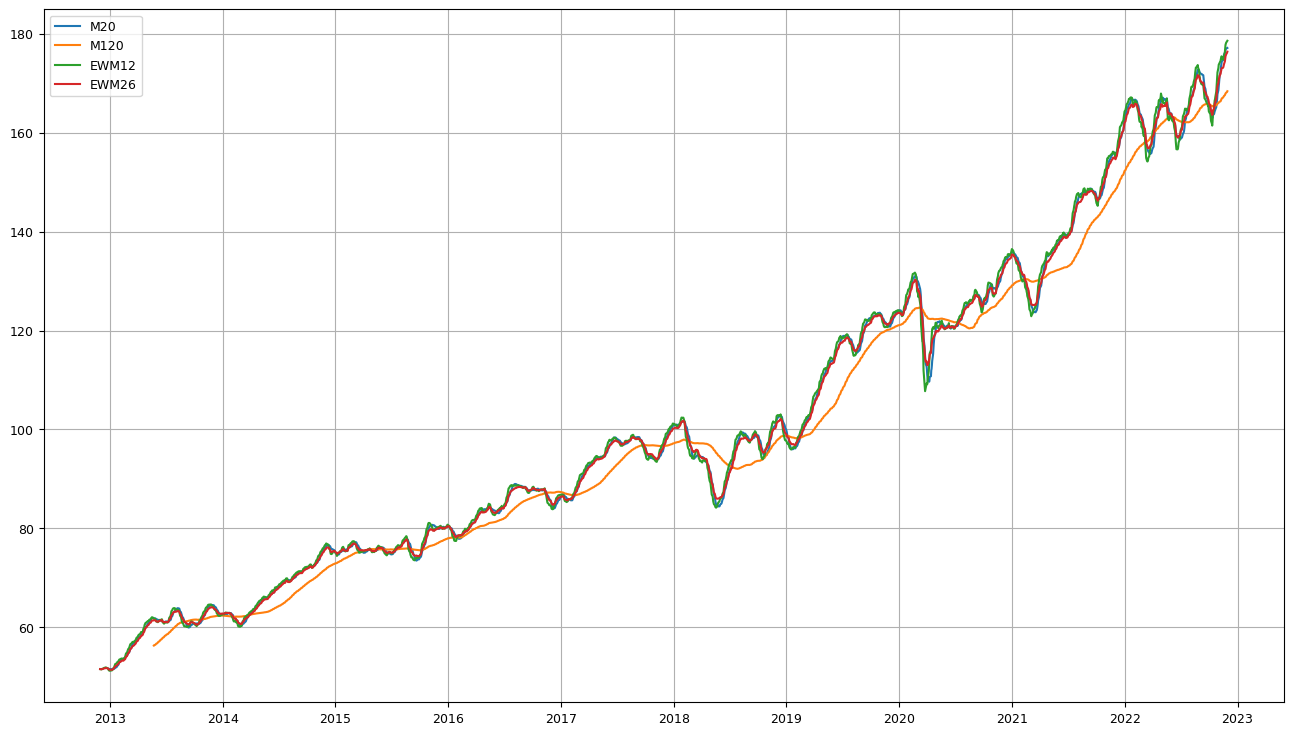

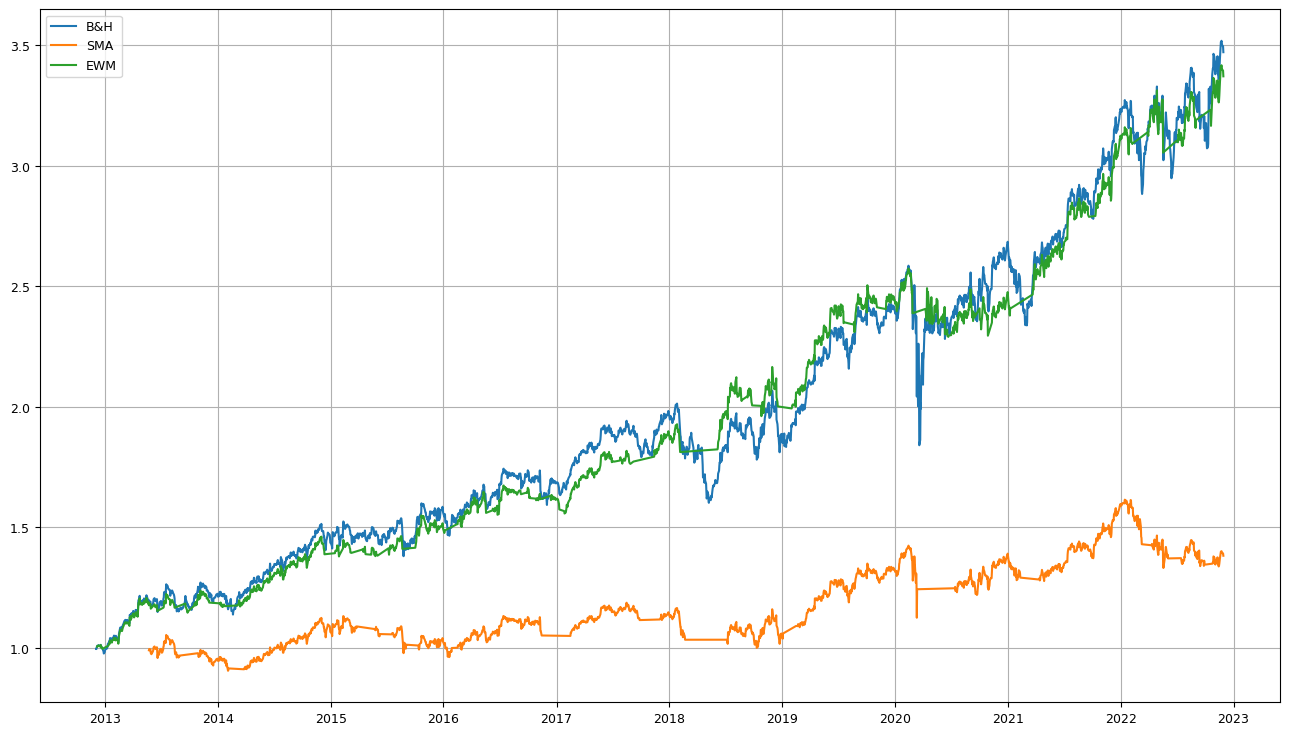

In [33]:
sma(PEP)

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 2.241137972840706
SMA return = 1.1733017897913343
EWM return = 1.8770978654761477


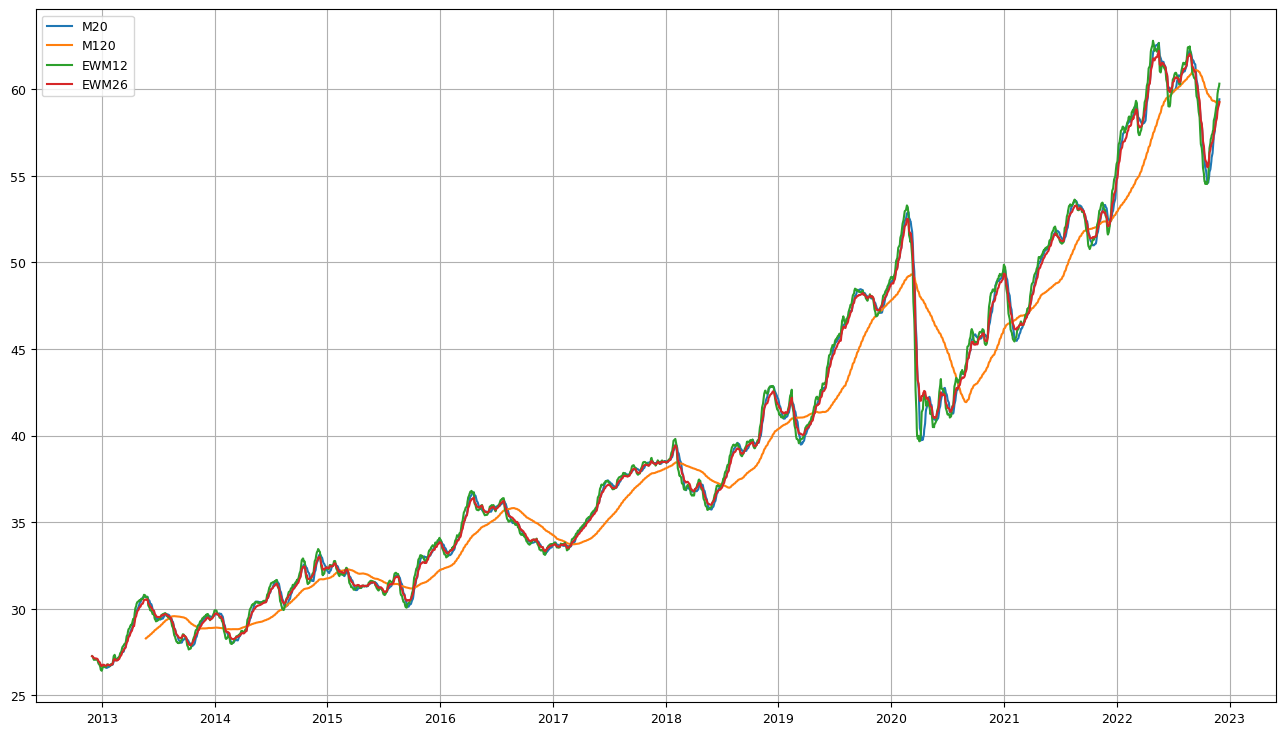

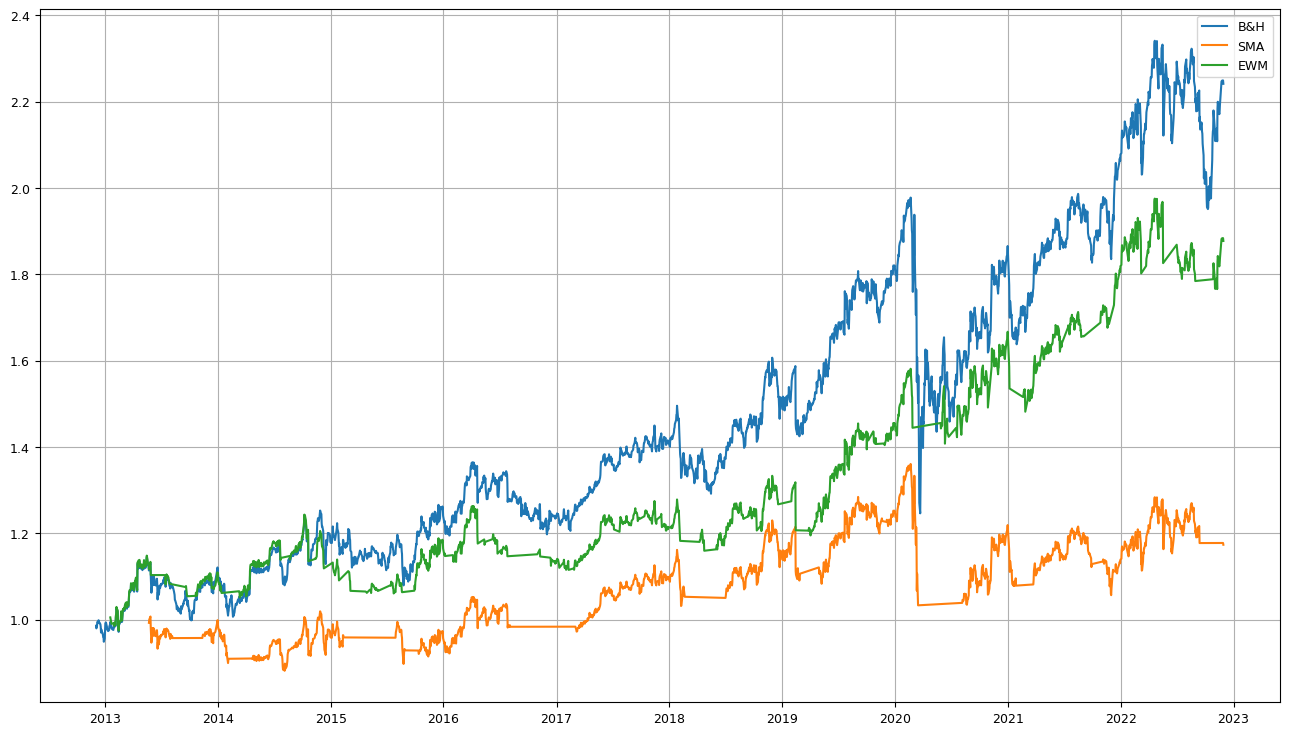

In [34]:
sma(KO)

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 7.333465459130718
SMA return = 4.1364177402360225
EWM return = 15.430805232158402


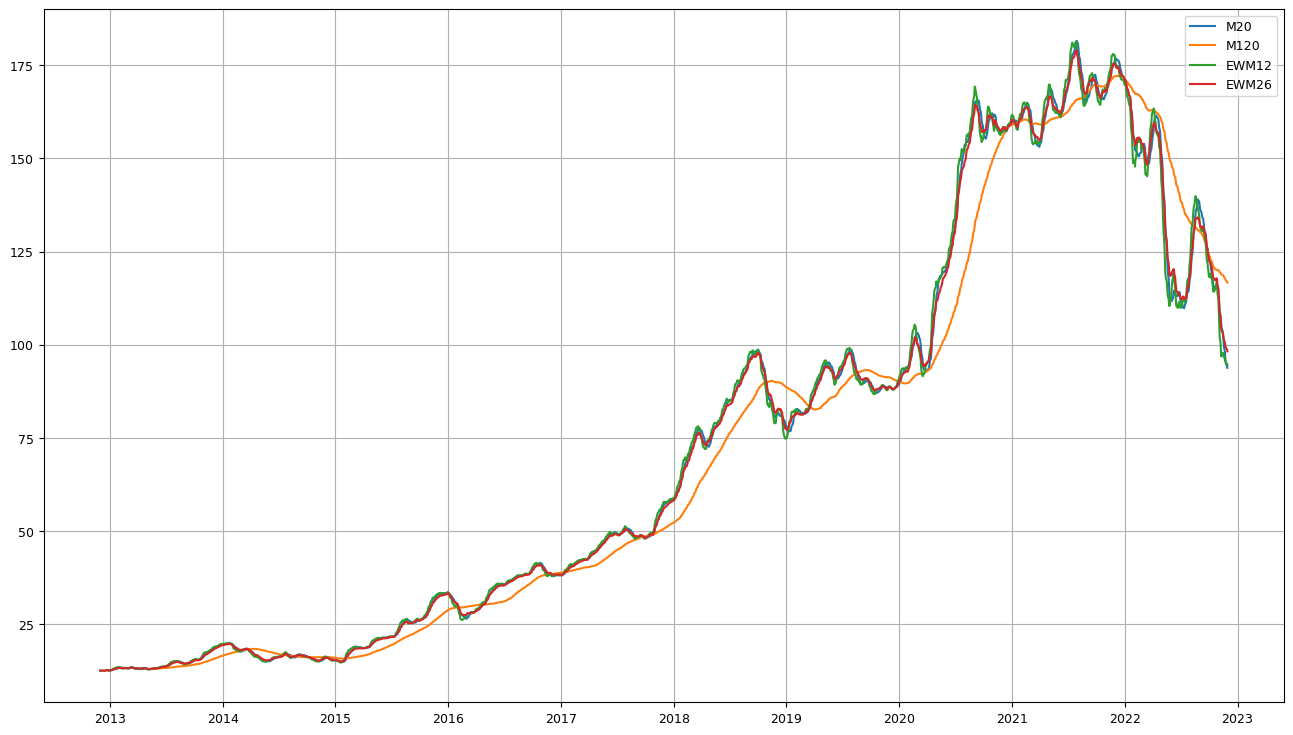

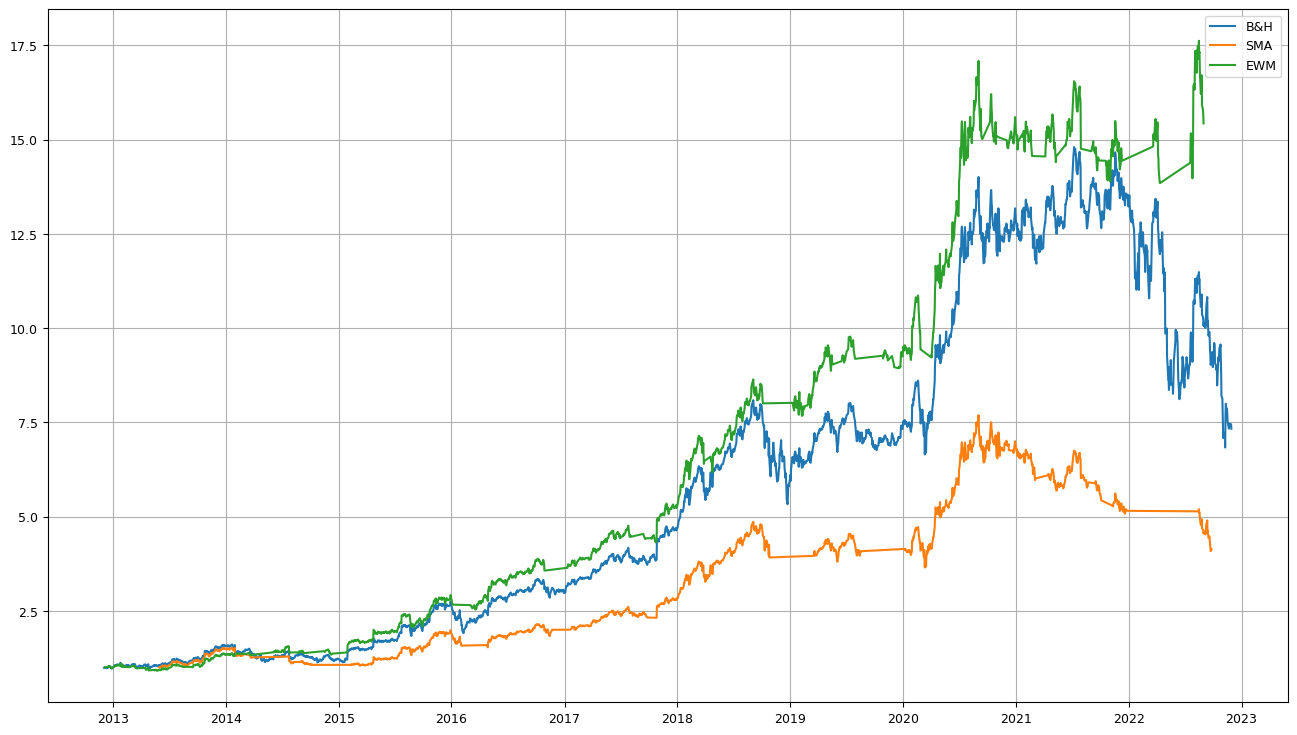

In [35]:
sma(AMZN)

C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change']) # calcolo il ritorno di questi valori
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\176677308.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy & Hold strategy return = 2.078046227161194
SMA return = 1.6305634462242686
EWM return = 4.547100366010278


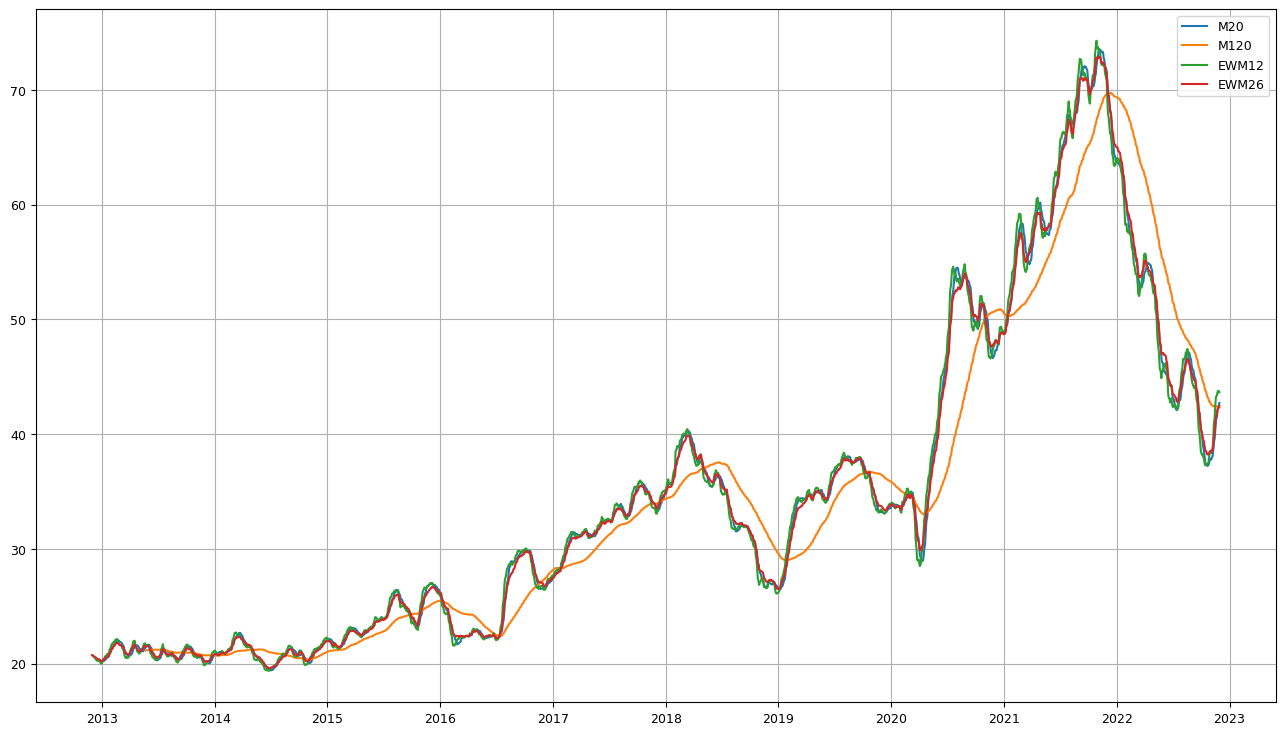

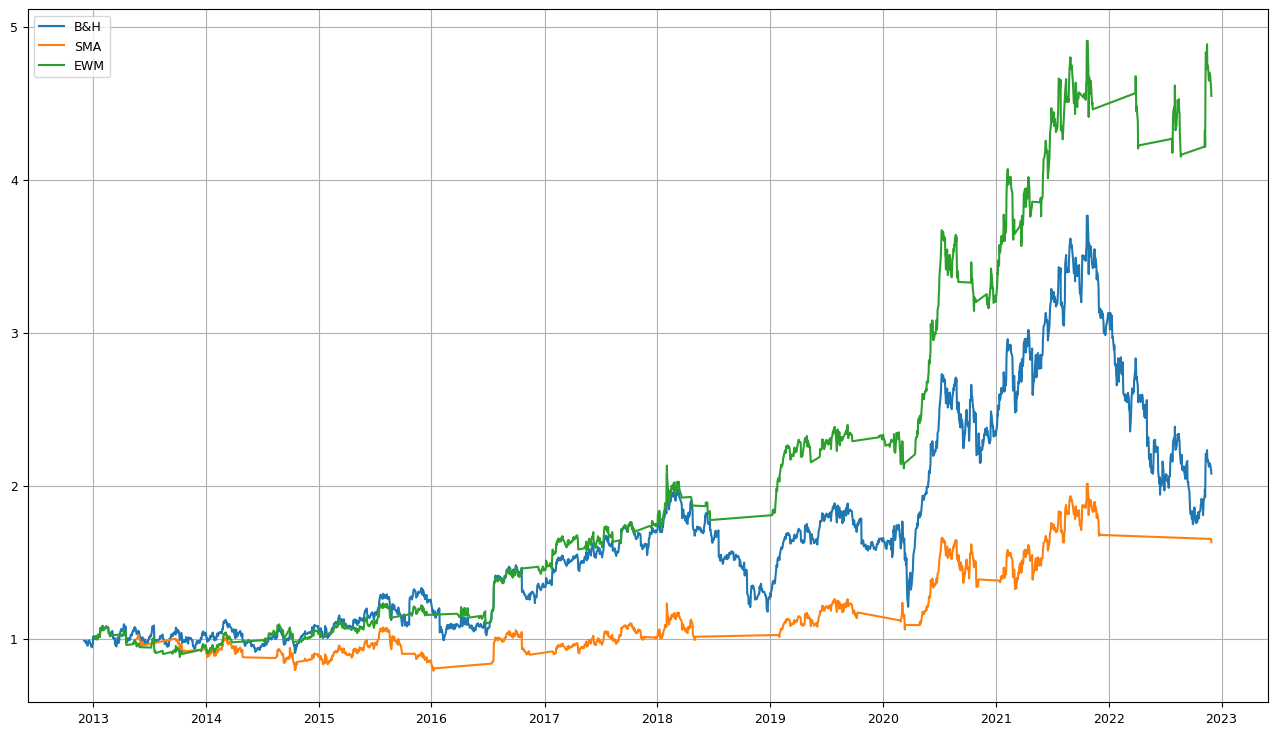

In [36]:
sma(EBAY)

In [37]:
# CAPM

SP500 = download('^GSPC')

def calcoloBeta(nome):
    X = pd.concat([DF_adj[nome], SP500['Adj Close']], axis = 1) #creo il df X con le colonne Adj Close dell'indice e del titolo
                                                                #di cui voglio calcolare il beta
    X.columns = ['asset', 'market'] #rinomino le colonne
    X = X.resample('M').last().pct_change().dropna() # raggruppo per mese, calcolo il rendimento ed elimino gli elementi NaN 
    covariance = X.cov().iloc[0, 1] #calcolo le varianze e seleziono la varianza dell'asset rispetto al mercato
    benchmark_variance = X.market.var() #calcolo la varianza del mercato
    beta = round(covariance / benchmark_variance, 3)
    print('La beta di ' + nome + ' è ' + str(beta))
    return beta
    

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3) #leggo il file CSV

#elimino i dati annuali in fondo al file
stringa = ' Annual Factors: January-December '
indices = factor_df.iloc[:,0] == stringa
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

#rinomino le colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']

#imposto come indice la data e seleziono l'intervallo voluto
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]

#divido tutto per 100
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

def modelloFamaFrench(nome):
    y = DF_adj[nome].resample('M').last().pct_change().dropna() #seleziono l'Adj Close dell'asset, reggruppo per mese e 
                                                                #calcolo il rendimento mensile
    y.index = y.index.strftime('%Y-%m') #rendo l'indice uguale a factor_df
    y.name = 'rtn' #cambio il nome della serie
    
    ff_data = factor_df.join(y) #unisco i due df
    ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf #calcolo i rendimenti in eccesso dell'asset rispetto al risk free
    
    ff_model = smf.ols(formula = 'excess_rtn ~ mkt + smb + hml', data = ff_data).fit()
    print(ff_model.summary())
    
calcoloBeta('JNJ')
modelloFamaFrench('JNJ')

calcoloBeta('PFE')
modelloFamaFrench('PFE')

calcoloBeta('PEP')
modelloFamaFrench('PEP')

calcoloBeta('KO')
modelloFamaFrench('KO')

calcoloBeta('AMZN')
modelloFamaFrench('AMZN')

calcoloBeta('EBAY')
modelloFamaFrench('EBAY')


[*********************100%***********************]  1 of 1 completed
La beta di JNJ è 0.624
                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     23.00
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           9.78e-12
Time:                        17:01:06   Log-Likelihood:                 230.17
No. Observations:                 119   AIC:                            -452.3
Df Residuals:                     115   BIC:                            -441.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [38]:
forecast_indice = 12

SP500_M = SP500.groupby(pd.Grouper(freq = 'M')).mean() 

df = pd.DataFrame(SP500_M['Adj Close']) #credo il dataframe con solo la colonna Adj Close
df['Prediction'] = df.shift(-forecast_indice) #creo la colonna prediction   

# Creiamo un data set indipendente (X), trasformando il df in un array
X = np.array(df.drop(['Prediction'], 1))
    
# Eliminiamo le ultime 110 righe
X = X[:-forecast_indice]
    
# Creiamo il data set dipendente (y)
y = np.array(df['Prediction'])
y = y[:-forecast_indice] #elimini gli elementi NaN

# Creo i train e test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
#creo e addestro un modello di regressione lineare
lr = LinearRegression() #creo il modello
lr.fit(x_test, y_test) #addestro il modello
lr_confindence = lr.score(x_test, y_test)
    
#creo la previsione degli ultimi 10 mesi
x_forecast = df.drop(['Prediction'],1)[-forecast_indice:] #selezioni gli ultimi 10 mesi
#print(x_forecast)
x_forecast['Adj Close'] = lr.predict(x_forecast) #creo la previsione degli ultimi 10 mesi
#print(x_forecast)
 
    
#plt.figure()
#plt.title("previsione di SP500")
#plt.plot(SP500_M['Adj Close'].iloc[-forecast_indice:], label = 'Effettivo')
#plt.plot(x_forecast['Adj Close'], label = 'Prev. LR')
#plt.grid(True)
#plt.legend();

#5c
#rendimento atteso dell'indice

exp_rtn_index = round(x_forecast['Adj Close'].iloc[-1] / x_forecast['Adj Close'].iloc[1], 2)
print('il rendimento atteso del indice è ' + str(exp_rtn_index))

#rendimento atteso del titolo
rf = 0.0389
def calcoloRA(nome):
    exp_rtn_asset = round(rf + (float(calcoloBeta(nome)) * exp_rtn_index), 2)
    print('il rendimento atteso di ' + nome + ' è: ' + str(exp_rtn_asset))

calcoloRA('JNJ')
calcoloRA('PFE')
calcoloRA('PEP')
calcoloRA('KO')
calcoloRA('AMZN')
calcoloRA('EBAY')

il rendimento atteso del indice è 0.87
La beta di JNJ è 0.624
il rendimento atteso di JNJ è: 0.58
La beta di PFE è 0.759
il rendimento atteso di PFE è: 0.7
La beta di PEP è 0.602
il rendimento atteso di PEP è: 0.56
La beta di KO è 0.604
il rendimento atteso di KO è: 0.56
La beta di AMZN è 1.278
il rendimento atteso di AMZN è: 1.15
La beta di EBAY è 1.285
il rendimento atteso di EBAY è: 1.16


C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2201514747.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['Prediction'], 1))
C:\Users\loren\AppData\Local\Temp\ipykernel_28080\2201514747.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_forecast = df.drop(['Prediction'],1)[-forecast_indice:] #selezioni gli ultimi 10 mesi
C:\Users\loren\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


[*********************100%***********************]  6 of 6 completed


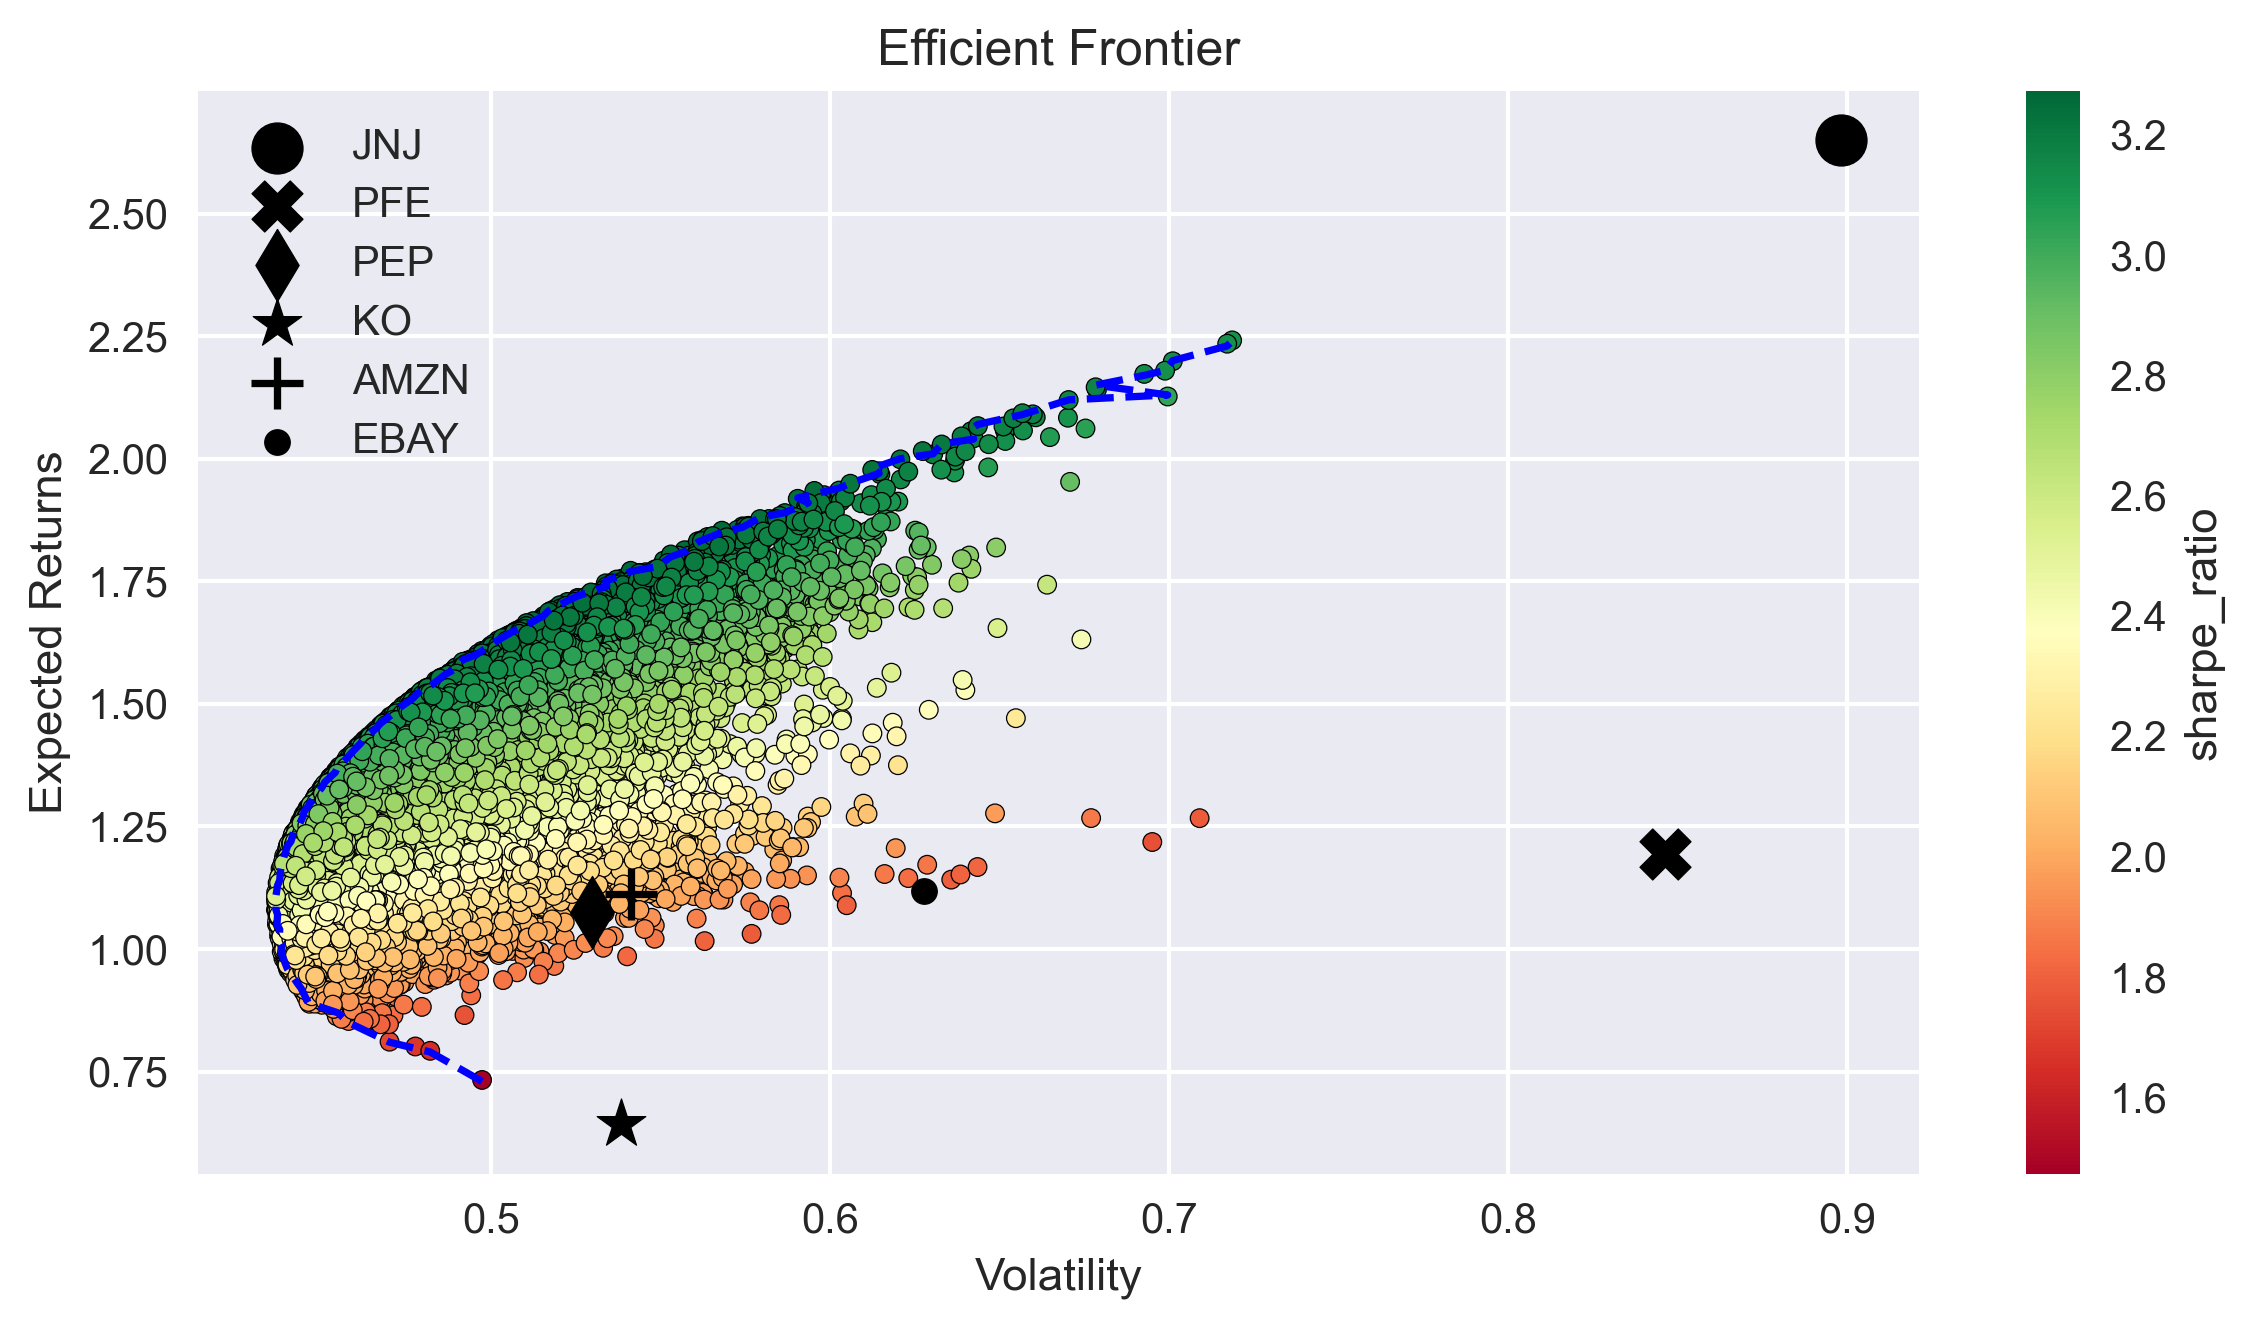

In [39]:
# ottimizzazione di portafoglio

plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# 6.a
assets = ['JNJ', 'PFE', 'PEP', 'KO', 'AMZN', 'EBAY']
prices_df = yf.download(assets, start_date, '2021-11-30')
n_port = 100000 #numero di portafogli
n_giorni = len(prices_df) #giorni
n_assets = len(assets) #asset

returns_df = np.log(prices_df['Adj Close'] / prices_df['Adj Close'].shift(1)).dropna()
cov_mat = returns_df.cov() * n_giorni #matrice di covarianza
avg_returns = returns_df.mean() * n_giorni #ritorno medio
np.random.seed(42)
weights = np.random.random(size=(n_port, n_assets))  #calcolo i pesi casuali
weights /=  np.sum(weights, axis=1)[:, np.newaxis] #li trasformo in percentuale

# calcolo i rendimenti di portafoglio

portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  #calcolo volatilità
portf_sharpe_ratio = portf_rtns / portf_vol #calcolo sharpe ratio

#creo un df con tutti i dati

portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

# trovo la forntiera efficiente

n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

#creo grafico

MARKS = ['o', 'X', 'd', '*', '+', '.']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=assets[asset_index])
ax.legend()

plt.tight_layout()
plt.show()



In [40]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

print('Maximum Sharpe Ratio portfolio')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)
    


Maximum Sharpe Ratio portfolio
Performance
returns: 177.14% volatility: 54.13% sharpe_ratio: 327.26% 
Weights
JNJ: 43.29% PFE: 1.31% PEP: 17.58% KO: 0.28% AMZN: 29.97% EBAY: 7.58% 

In [41]:
print('Minimum Volatility portfolio')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio
Performance
returns: 107.99% volatility: 43.67% sharpe_ratio: 247.31% 
Weights
JNJ: 7.36% PFE: 9.55% PEP: 26.60% KO: 30.65% AMZN: 14.01% EBAY: 11.82% 

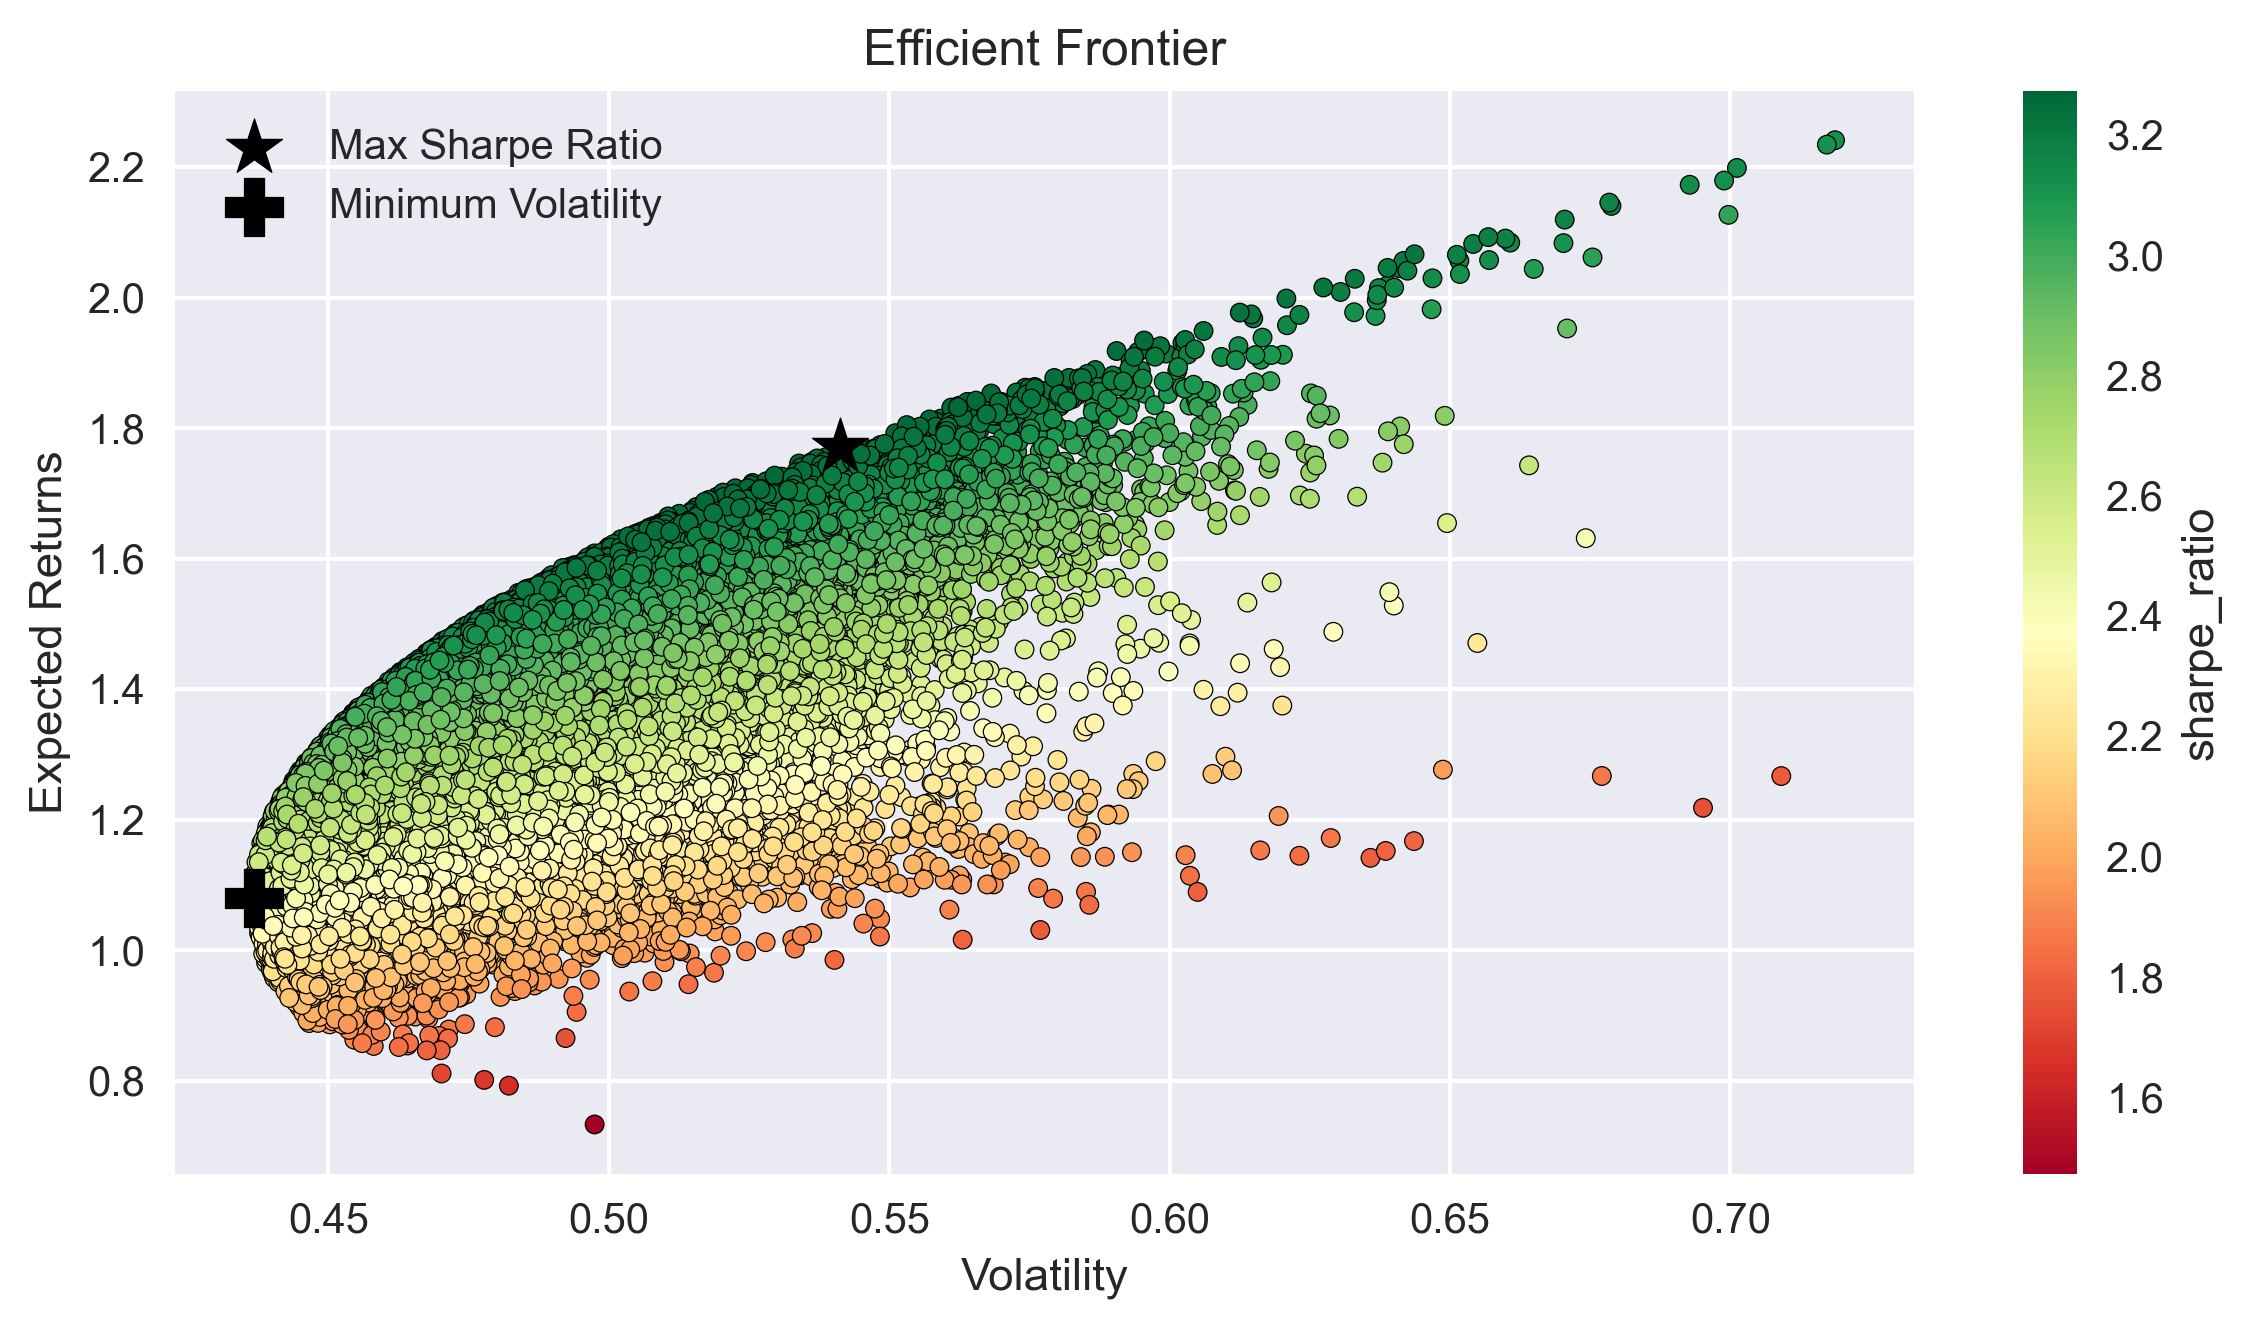

In [42]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


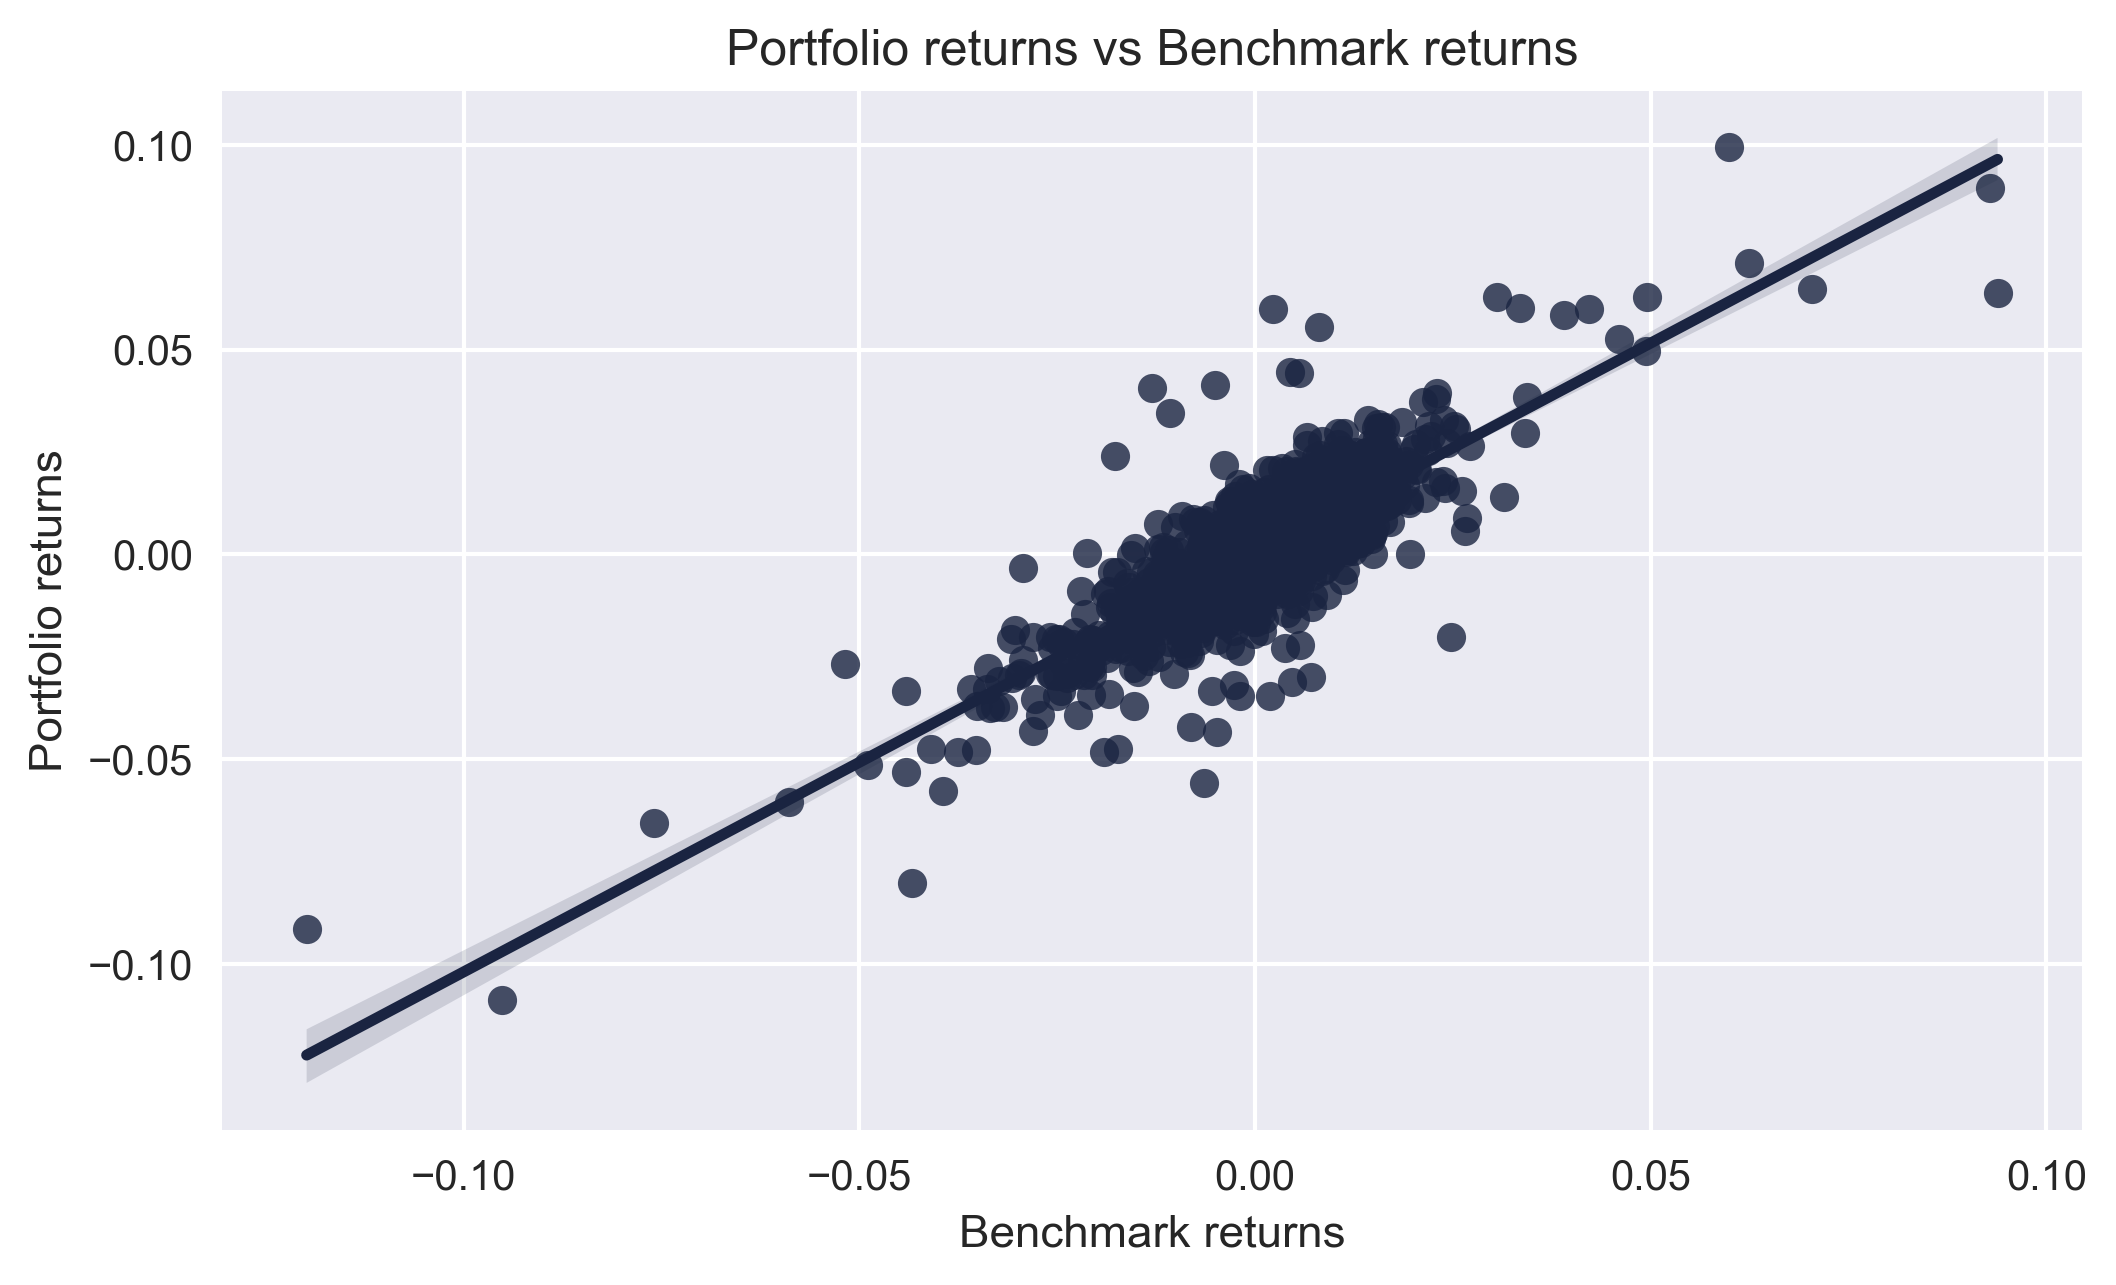

il beta del portafoglio è  1.024


In [43]:
# beta del portafoglio

from scipy import stats

weights_max_SR = [0.4329, 0.0131, 0.1758, 0.2800, 0.2997, 0.0758]
SP500_b = yf.download('^GSPC', start_date, '2021-11-30')
benchmark_price = SP500_b['Adj Close']
port_ret = ((prices_df['Adj Close'].pct_change()[1:]) * weights_max_SR).sum(axis = 1)

benchmark_ret = benchmark_price.pct_change()[1:]
sns.regplot(benchmark_ret.values, port_ret)
plt.xlabel('Benchmark returns')
plt.ylabel('Portfolio returns')
plt.title('Portfolio returns vs Benchmark returns')
plt.show()
(beta, alpha) = stats.linregress(benchmark_ret.values, port_ret)[0:2]
print('il beta del portafoglio è ', round(beta, 3))

In [44]:
# portafoglio effettivo
pesi_effettivi = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]
portafoglio_effettivo = pesi_effettivi * DF_cumulato_Y

round(sum(portafoglio_effettivo), 3)

2.597

In [45]:
portafoglio_ottimale = weights_max_SR * DF_cumulato_Y

round(sum(portafoglio_ottimale), 3)

3.821